In [1]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import re
#from keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

### Lectura de ficheros

In [2]:
df = pd.read_csv('FicheroPrueba5.csv', lineterminator = '\n')

C:\Users\Hector\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df2 = df[df['lang'].str.contains('en')]

In [4]:
df.columns

Index(['Unnamed: 0', 'id', 'text', 'tweet_created_at', 'lang', 'entities',
       'source', 'is_quote_status', 'truncated', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'in_reply_to_screen_name', 'coordinates',
       'place', 'is_quote_status.1', 'retweet_count', 'user.id', 'user.name',
       'user.location', 'user.description', 'user.followers_count',
       'user.friends_count', 'user.created_at', 'user.favourites_count',
       'user.verified', 'profile_image_url', 'user.profile_image_url_https',
       'user_all_data\r\r', 'ratio_favs_followers', 'ratio_retweets_followers',
       'number_emojis', 'created_after_war', 'num_tweets', 'num_mentions',
       'num_mentions_user', 'earliest_tweeting_date', 'latest_tweeting_date',
       'days_interval', 'ratio_tweets_dias', 'langs_tweeted', 'lang_number',
       'num_hashtags', 'only_hashtags', 'is_image_default', 'is_rt',
       'are_mentions_in_tweet', 'embeddings', 'cosine', 'cosine_avg',
       'num_rts', 'sentiment\r'],


### Preparación previa para utilizar los modelos

In [4]:
dataframe = df[df['lang'].str.contains('en')]

In [5]:
dataframe = dataframe.filter(['embeddings', 'retweet_count', 'user.followers_count', 'user.friends_count', 'user.favourites_count',
                             'ratio_favs_followers', 'ratio_retweets_followers', 'number_emojis', 'created_after_war', 
                              'num_tweets', 'ratio_tweets_dias', 'lang_number',
                             'num_hashtags', 'is_image_default', 'is_rt', 'are_mentions_in_tweet', 
                              'num_mentions','num_mentions_user', 'cosine_avg', 'num_rts', 'sentiment\r'])

In [6]:
dataframe['words_transformed'] = list(map(lambda x: [float(num) for num in x.strip('[]').split()], dataframe['embeddings']))

In [7]:
dataframe = dataframe.filter(['words_transformed', 'retweet_count', 'user.followers_count', 'user.friends_count', 'user.favourites_count',
                             'ratio_favs_followers', 'ratio_retweets_followers', 'number_emojis', 'created_after_war', 
                              'num_tweets', 'ratio_tweets_dias', 'lang_number',
                             'num_hashtags', 'is_image_default', 'is_rt', 'are_mentions_in_tweet', 
                              'num_mentions','num_mentions_user', 'cosine_avg', 'num_rts', 'sentiment\r'])

In [8]:
new_df = dataframe['words_transformed'].apply(pd.Series)

In [9]:
new_df.columns = ['word_embeddings_{}'.format(x) for x in new_df.columns]

In [10]:
dataframe_temp = pd.concat([dataframe, new_df], axis=1)

In [11]:
dataframe2 = dataframe.drop(columns = 'words_transformed')

In [12]:
dataframe3 = dataframe_temp.drop(columns = 'words_transformed')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
    
for i in dataframe2.columns:
    if isinstance(dataframe2[i][0], (int, float)):
        datos = dataframe2[i].tolist()
        media = round(dataframe2[i].mean(),4)
        desviacion_estandar = round(dataframe2[i].std(),4)

        #plt.hist(datos, bins=10, alpha=0.5, color='blue')import seaborn as sns

        sns.histplot(datos, bins=10, alpha=0.5, color='blue', kde = True)
        plt.title(str(i))
        plt.axvline(x=media, color='red', linestyle='dashed', linewidth=2)
        plt.text(media+0.1, 1, 'Media', color='red')
        plt.axvline(x=media+desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
        plt.text(media+desviacion_estandar+0.1, 1, 'Desv. Std.', color='green')
        plt.axvline(x=media-desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
        plt.text(media-desviacion_estandar-0.8, 1, 'Desv. Std.', color='green')
        plt.show()
    
print("\n\n")

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 3000))

# normalize the DataFrame
df_norm = pd.DataFrame(scaler.fit_transform(dataframe2), columns=dataframe2.columns)
df_norm2 = pd.DataFrame(scaler.fit_transform(dataframe3), columns=dataframe3.columns)


### Entrenamiento OPTICS

In [ ]:
from sklearn.cluster import OPTICS

optics_clustering = OPTICS(min_samples = 250).fit(df_norm)

In [ ]:
labels = optics_clustering.labels_

### Gráfico para determinar el epsilon de DBSCAN

In [35]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

In [101]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_norm)
distances, indices = neighbors_fit.kneighbors(df_norm)

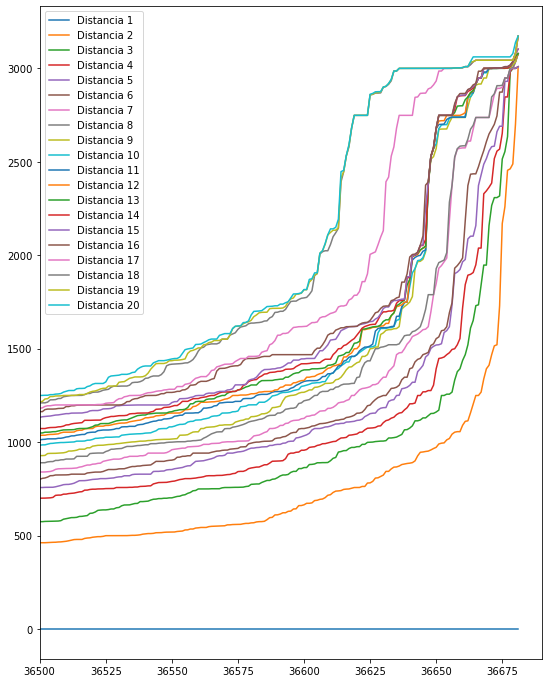

In [107]:
#Quitar truncado, añadir leyenda
#Mas alto que ancho

distances = np.sort(distances, axis=0)
labels = ['Distancia {}'.format(i+1) for i in range(distances.shape[1])]
#distances = distances[:,1]
plt.xlim(36500, 36690)

plt.plot(distances)
plt.legend(labels = labels)
plt.show()

### Entrenamiento de DBSCAN

In [58]:
db = DBSCAN(eps=700, min_samples=50).fit(df_norm)

In [59]:
labels = db.labels_

In [60]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 21
Estimated number of noise points: 823


In [21]:
df2['DBSCAN'] = labels

<ipython-input-21-c6ea942dc266>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['DBSCAN'] = labels


In [22]:
groups = df2.groupby('DBSCAN')

In [23]:
pd.set_option('display.max_colwidth', None)



Cluster -1: 823 rows
Average number of tweets of a user being retweeted: 505.8202 ------> Standard deviation: 3253.8714
Average number of emojis: 0.5079 ------> Standard deviation: 2.5521
User followers: 211127.3281 ------> Standard deviation: 2627257.9049
User followed: 3433.2612 ------> Standard deviation: 27594.2799
Ratio favs_followers: 989.4554 ------> Standard deviation: 6331.3334
Ratio retweets_followers: 78.4828 ------> Standard deviation: 811.1031
Average number of hashtags: 1.8493 ------> Standard deviation: 3.1184
Average number of tweets: 22.2139 ------> Standard deviation: 36.6905
Average number of retweets: 13.7521 ------> Standard deviation: 37.1184
Average number of languages: 1.3767 ------> Standard deviation: 1.9159
Ratio tweets by day: 22.2139 ------> Standard deviation: 36.6905
Average number of emojis: 0.5079 ------> Standard deviation: 2.5521
Average number of mentions in each tweet: 2.0778 ------> Standard deviation: 3.0469
Average number of mentions by user: 3

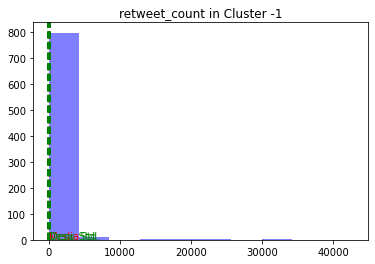

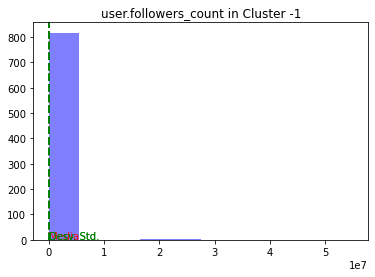

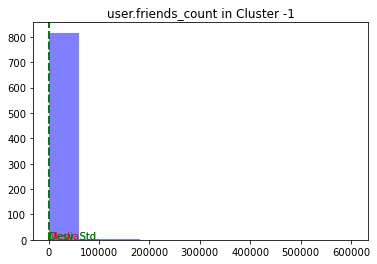

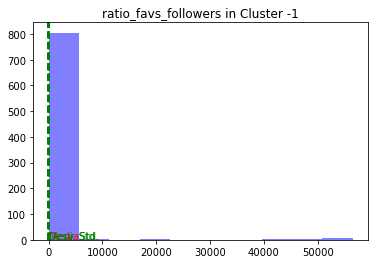

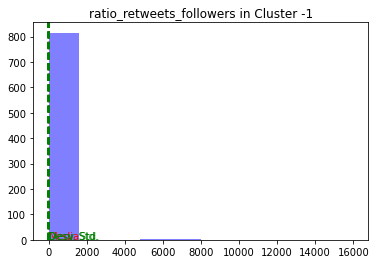

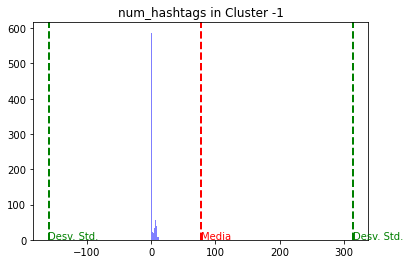

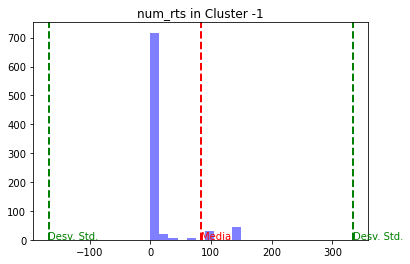

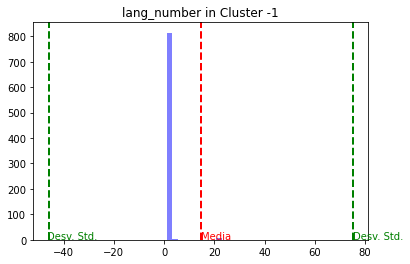

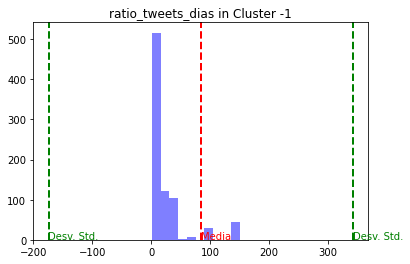

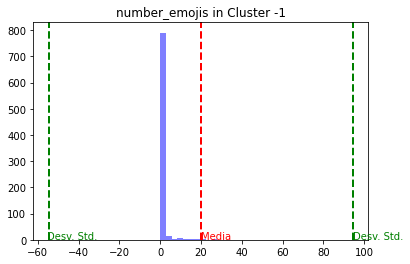

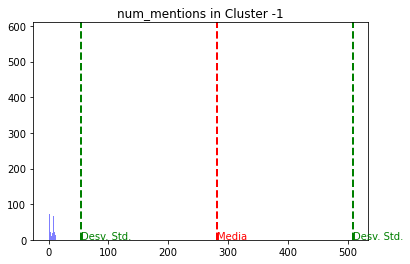

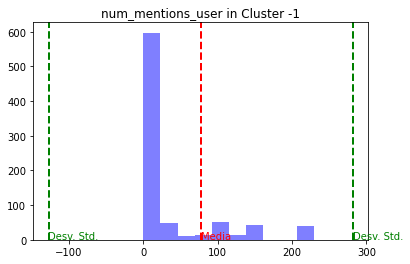

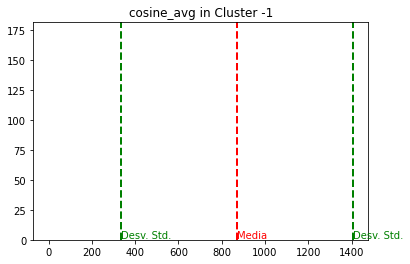






Cluster 0: 13751 rows
Average number of tweets of a user being retweeted: 687.5458 ------> Standard deviation: 1560.939
Average number of emojis: 0.178 ------> Standard deviation: 0.5649
User followers: 6297.9891 ------> Standard deviation: 166068.6866
User followed: 2545.2504 ------> Standard deviation: 6099.4187
Ratio favs_followers: 177.9855 ------> Standard deviation: 403.0695
Ratio retweets_followers: 10.2182 ------> Standard deviation: 99.285
Average number of hashtags: 0.2837 ------> Standard deviation: 0.7811
Average number of tweets: 4.7865 ------> Standard deviation: 8.8255
Average number of retweets: 4.6699 ------> Standard deviation: 8.7727
Average number of languages: 1.1046 ------> Standard deviation: 0.3346
Ratio tweets by day: 4.7865 ------> Standard deviation: 8.8255
Average number of emojis: 0.178 ------> Standard deviation: 0.5649
Average number of mentions in each tweet: 1.1577 ------> Standard deviation: 0.4623
Average number of mentions by user: 5.4656 ------

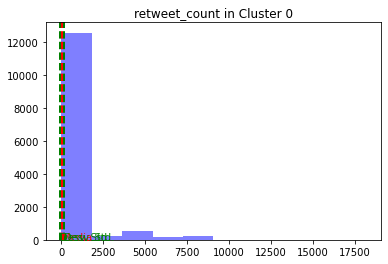

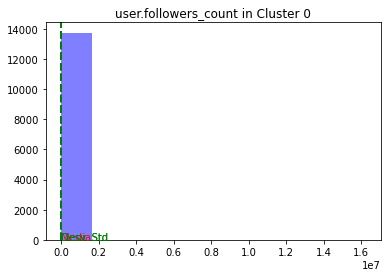

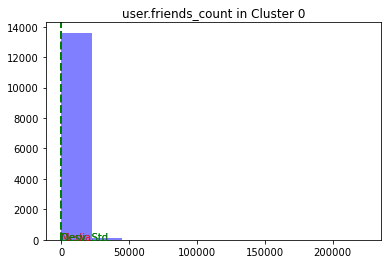

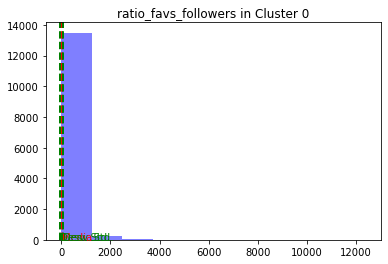

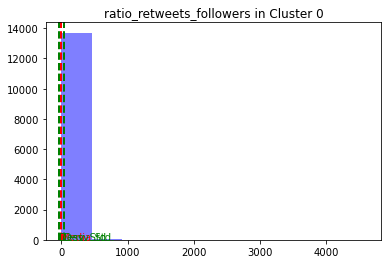

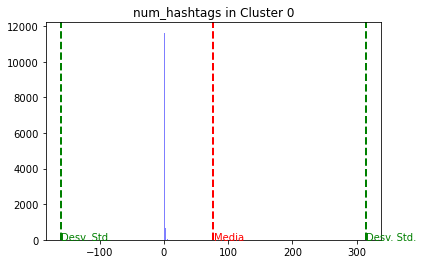

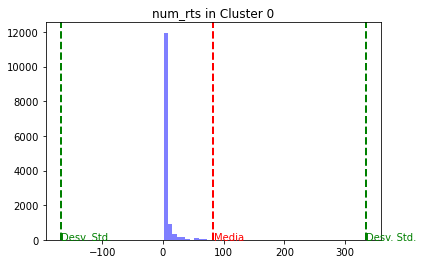

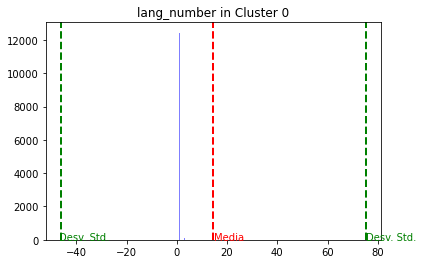

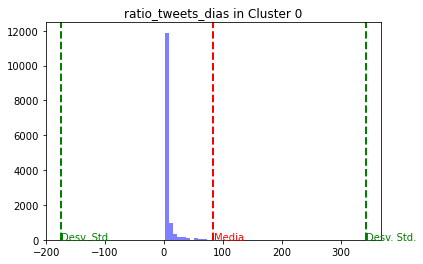

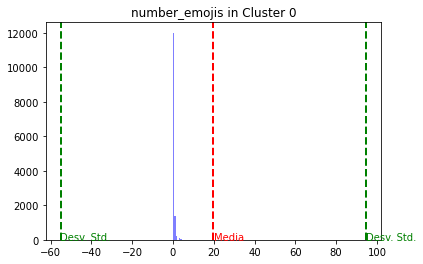

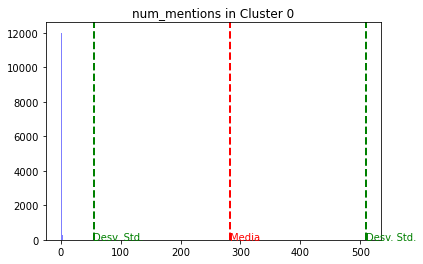

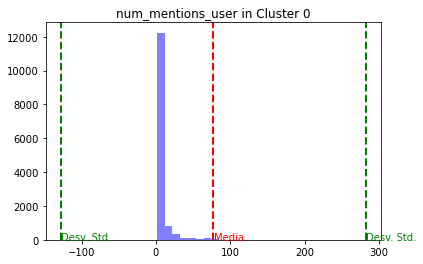

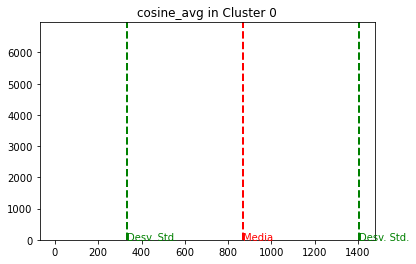






Cluster 1: 5624 rows
Average number of tweets of a user being retweeted: 609.5461 ------> Standard deviation: 1180.118
Average number of emojis: 0.2283 ------> Standard deviation: 0.5743
User followers: 4596.9404 ------> Standard deviation: 36924.032
User followed: 2638.6529 ------> Standard deviation: 5333.3776
Ratio favs_followers: 176.1307 ------> Standard deviation: 434.7648
Ratio retweets_followers: 6.069 ------> Standard deviation: 38.7808
Average number of hashtags: 0.2443 ------> Standard deviation: 0.7356
Average number of tweets: 4.732 ------> Standard deviation: 8.6731
Average number of retweets: 4.6046 ------> Standard deviation: 8.6169
Average number of languages: 1.1056 ------> Standard deviation: 0.3398
Ratio tweets by day: 4.732 ------> Standard deviation: 8.6731
Average number of emojis: 0.2283 ------> Standard deviation: 0.5743
Average number of mentions in each tweet: 1.2027 ------> Standard deviation: 0.5747
Average number of mentions by user: 5.4287 ------> St

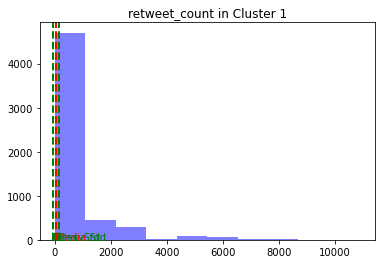

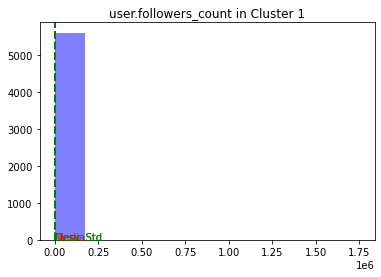

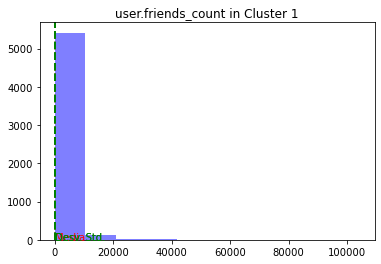

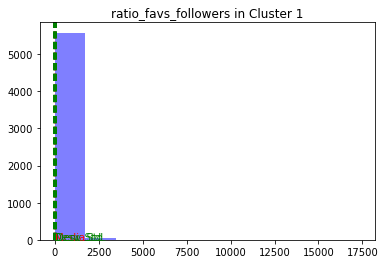

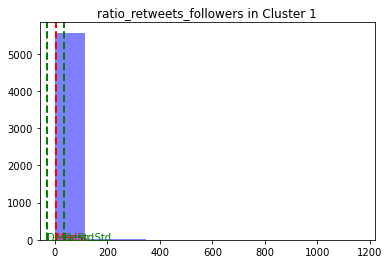

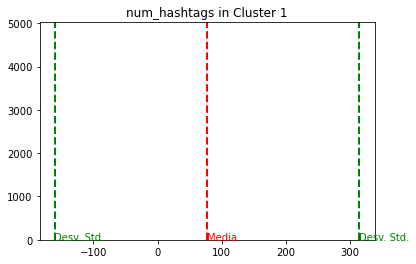

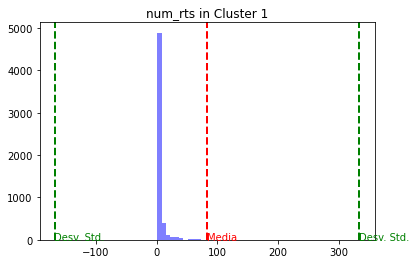

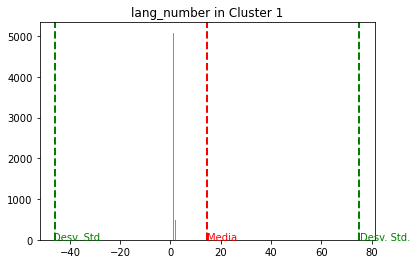

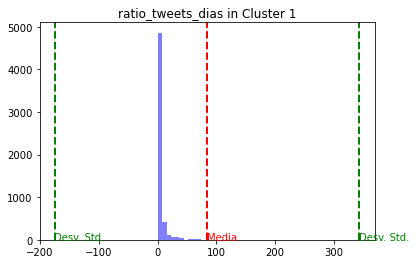

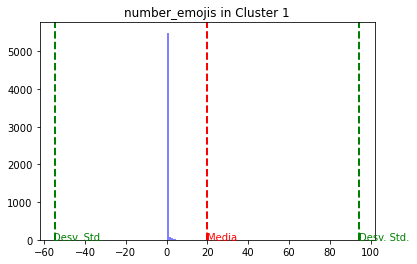

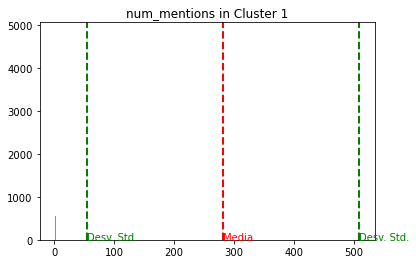

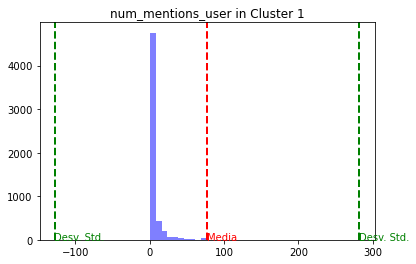

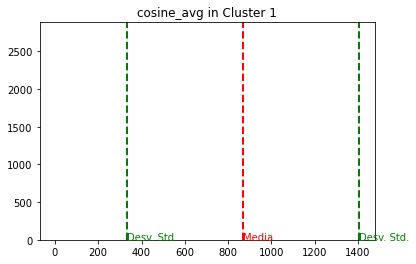






Cluster 2: 728 rows
Average number of tweets of a user being retweeted: 2.7665 ------> Standard deviation: 14.7784
Average number of emojis: 0.1236 ------> Standard deviation: 0.4733
User followers: 80936.5907 ------> Standard deviation: 718313.6802
User followed: 2233.1305 ------> Standard deviation: 4396.4318
Ratio favs_followers: 32.9132 ------> Standard deviation: 94.5366
Ratio retweets_followers: 0.001 ------> Standard deviation: 0.0074
Average number of hashtags: 0.3736 ------> Standard deviation: 0.8858
Average number of tweets: 3.1209 ------> Standard deviation: 4.573
Average number of retweets: 0.3173 ------> Standard deviation: 1.0631
Average number of languages: 1.0797 ------> Standard deviation: 0.2999
Ratio tweets by day: 3.1209 ------> Standard deviation: 4.573
Average number of emojis: 0.1236 ------> Standard deviation: 0.4733
Average number of mentions in each tweet: 0.0618 ------> Standard deviation: 0.241
Average number of mentions by user: 0.7775 ------> Standar

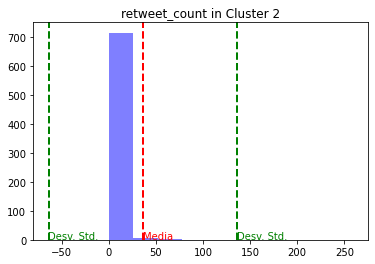

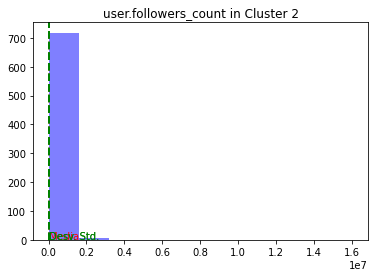

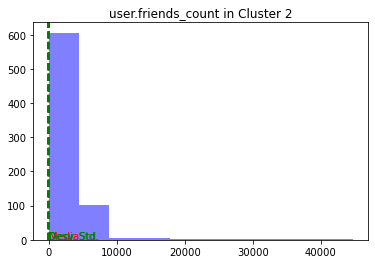

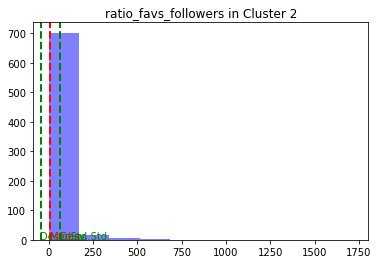

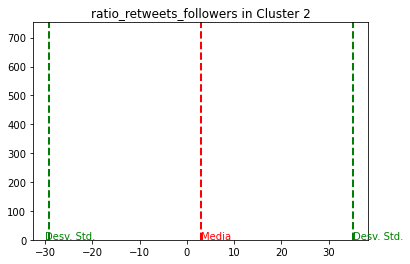

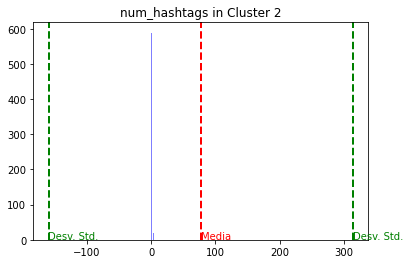

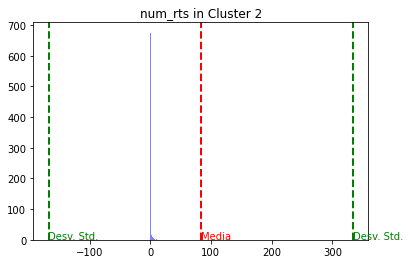

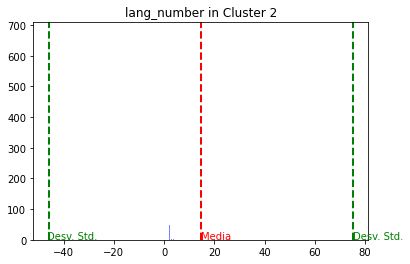

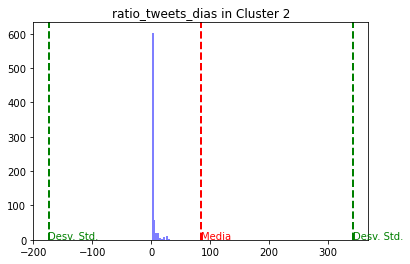

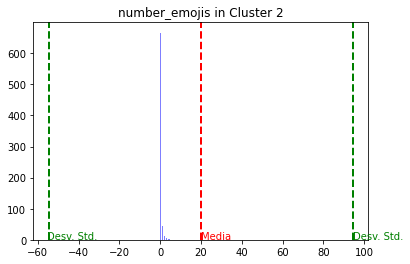

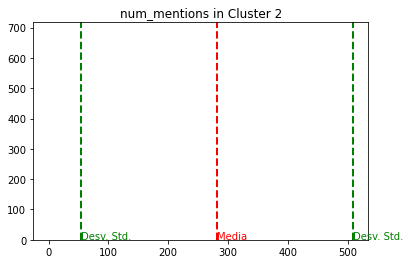

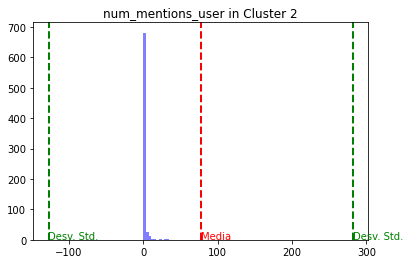

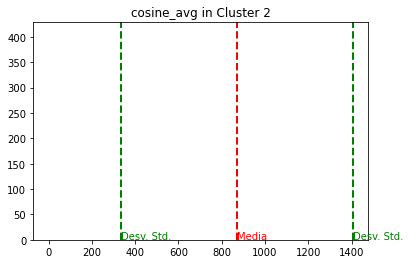






Cluster 3: 2890 rows
Average number of tweets of a user being retweeted: 0.1221 ------> Standard deviation: 1.0687
Average number of emojis: 0.1069 ------> Standard deviation: 0.5965
User followers: 3152.9166 ------> Standard deviation: 30817.0621
User followed: 1156.1048 ------> Standard deviation: 2065.4123
Ratio favs_followers: 109.4569 ------> Standard deviation: 289.4626
Ratio retweets_followers: 0.0012 ------> Standard deviation: 0.0384
Average number of hashtags: 0.0689 ------> Standard deviation: 0.3801
Average number of tweets: 2.3381 ------> Standard deviation: 2.724
Average number of retweets: 0.2536 ------> Standard deviation: 1.183
Average number of languages: 1.0256 ------> Standard deviation: 0.1665
Ratio tweets by day: 2.3381 ------> Standard deviation: 2.724
Average number of emojis: 0.1069 ------> Standard deviation: 0.5965
Average number of mentions in each tweet: 2.1059 ------> Standard deviation: 1.5685
Average number of mentions by user: 4.9526 ------> Standa

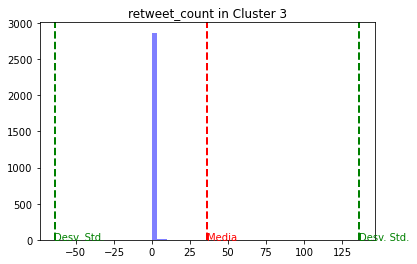

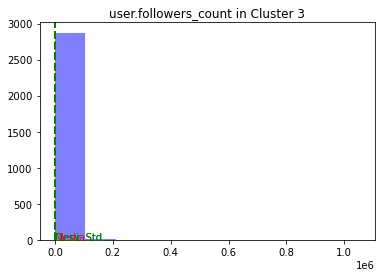

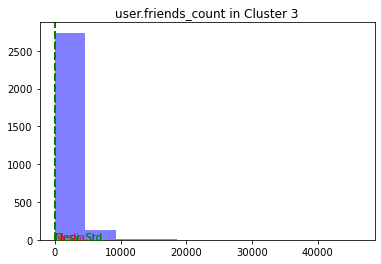

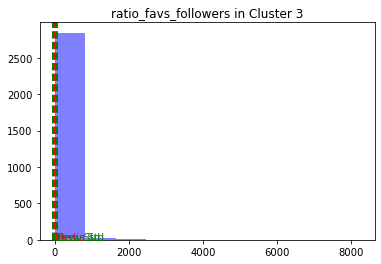

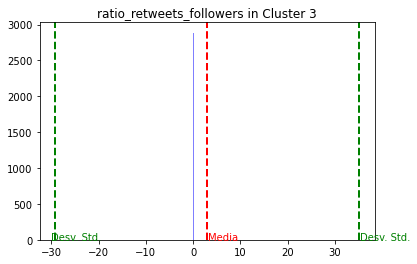

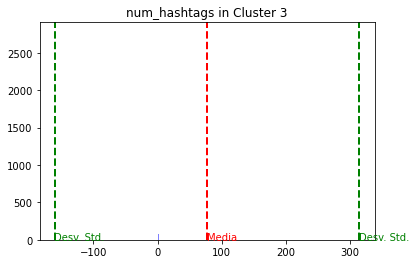

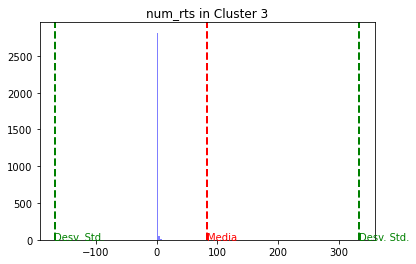

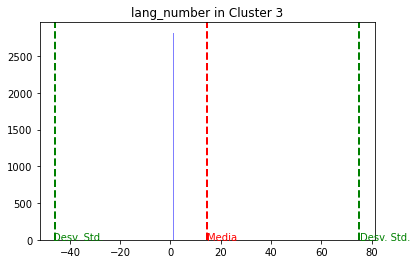

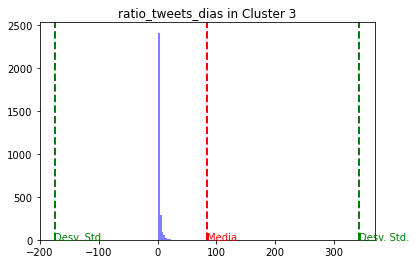

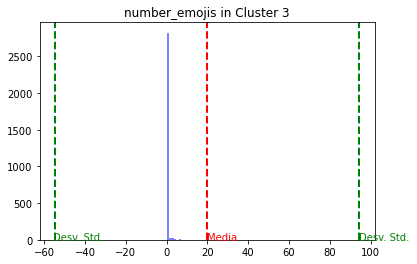

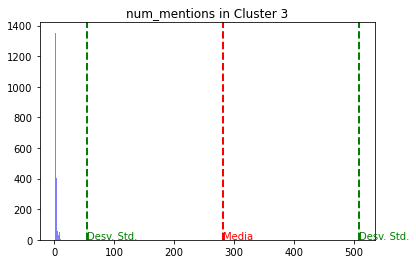

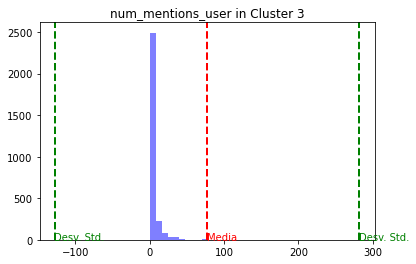

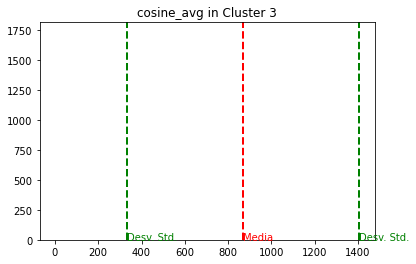






Cluster 4: 1156 rows
Average number of tweets of a user being retweeted: 0.1228 ------> Standard deviation: 0.9382
Average number of emojis: 0.1514 ------> Standard deviation: 0.7138
User followers: 2497.5052 ------> Standard deviation: 15615.4374
User followed: 1197.5346 ------> Standard deviation: 2685.4278
Ratio favs_followers: 106.4358 ------> Standard deviation: 227.4977
Ratio retweets_followers: 0.0005 ------> Standard deviation: 0.0099
Average number of hashtags: 0.058 ------> Standard deviation: 0.3471
Average number of tweets: 2.2543 ------> Standard deviation: 2.6022
Average number of retweets: 0.2734 ------> Standard deviation: 1.1448
Average number of languages: 1.0216 ------> Standard deviation: 0.157
Ratio tweets by day: 2.2543 ------> Standard deviation: 2.6022
Average number of emojis: 0.1514 ------> Standard deviation: 0.7138
Average number of mentions in each tweet: 1.8478 ------> Standard deviation: 1.124
Average number of mentions by user: 4.3348 ------> Standa

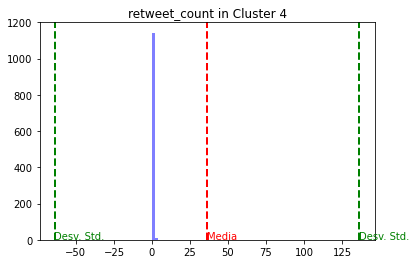

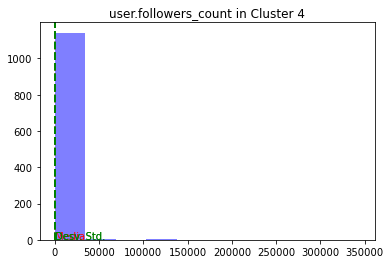

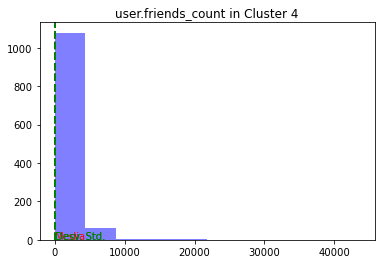

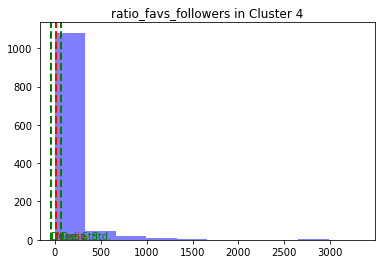

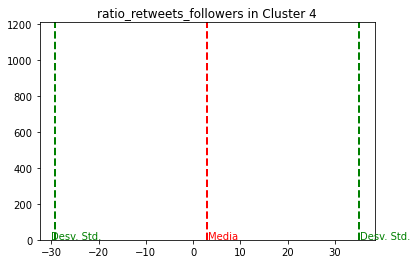

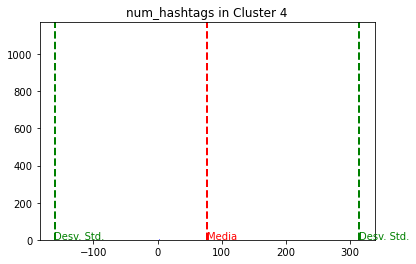

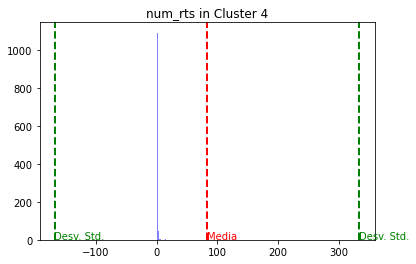

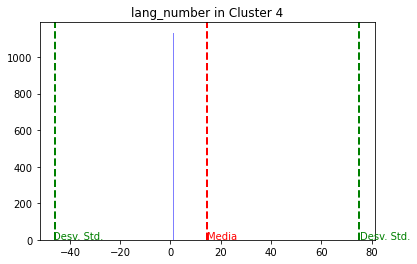

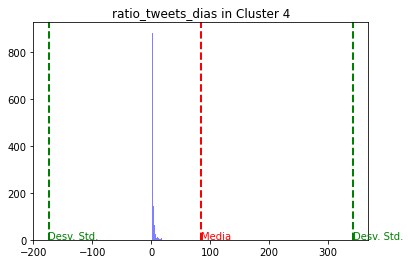

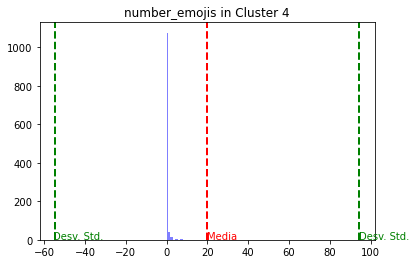

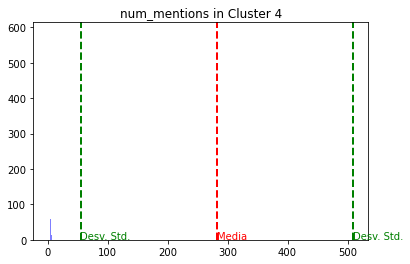

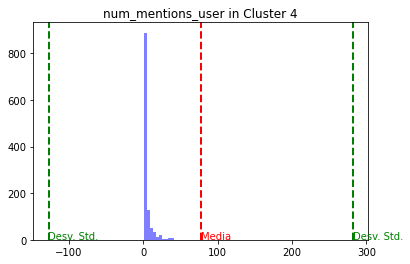

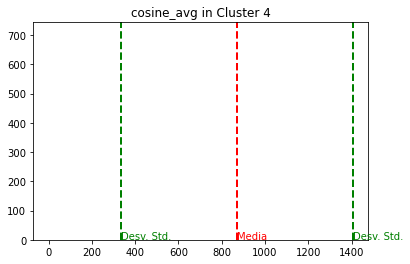






Cluster 5: 1272 rows
Average number of tweets of a user being retweeted: 667.82 ------> Standard deviation: 1450.3336
Average number of emojis: 0.2358 ------> Standard deviation: 0.6024
User followers: 598.7052 ------> Standard deviation: 2189.6652
User followed: 884.2964 ------> Standard deviation: 1493.8703
Ratio favs_followers: 202.5961 ------> Standard deviation: 423.5173
Ratio retweets_followers: 50.4256 ------> Standard deviation: 231.5524
Average number of hashtags: 0.3137 ------> Standard deviation: 0.8834
Average number of tweets: 4.0818 ------> Standard deviation: 5.343
Average number of retweets: 3.9277 ------> Standard deviation: 5.2827
Average number of languages: 1.1219 ------> Standard deviation: 0.3658
Ratio tweets by day: 4.0818 ------> Standard deviation: 5.343
Average number of emojis: 0.2358 ------> Standard deviation: 0.6024
Average number of mentions in each tweet: 1.1769 ------> Standard deviation: 0.4819
Average number of mentions by user: 4.6958 ------> St

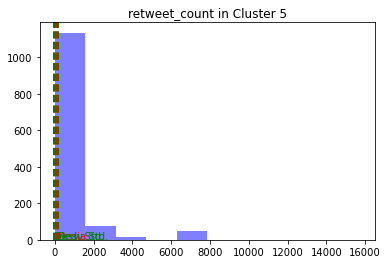

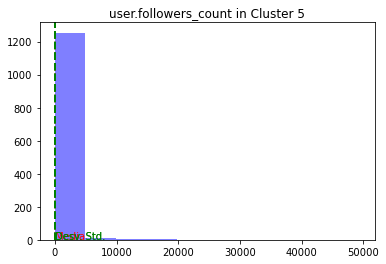

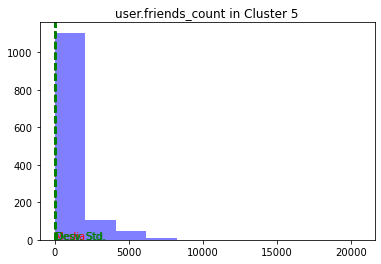

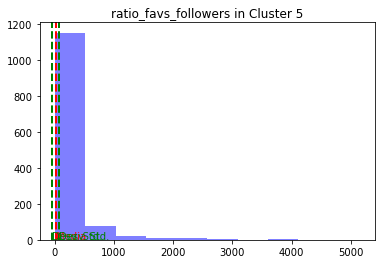

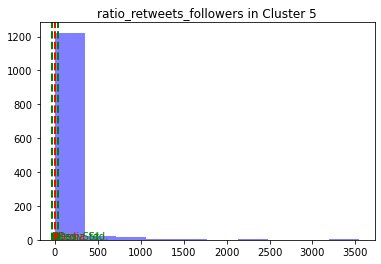

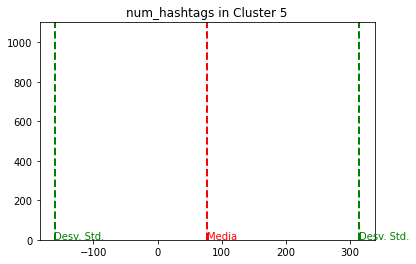

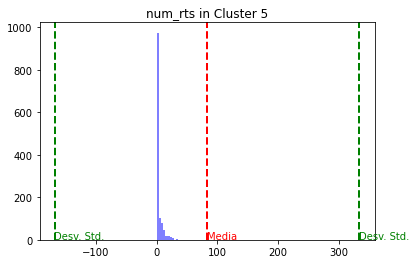

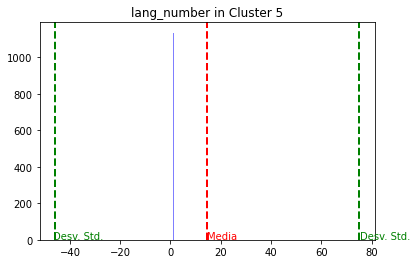

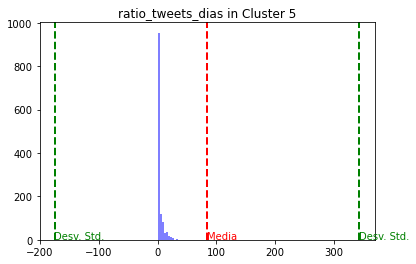

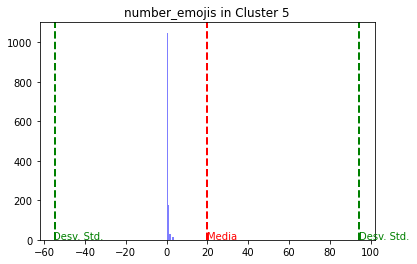

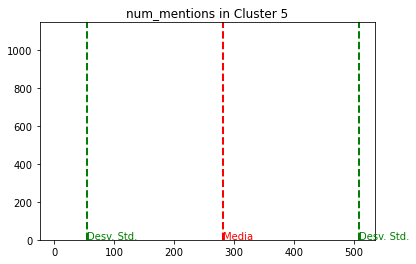

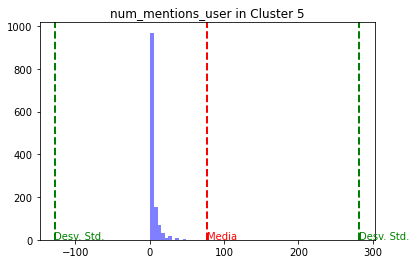

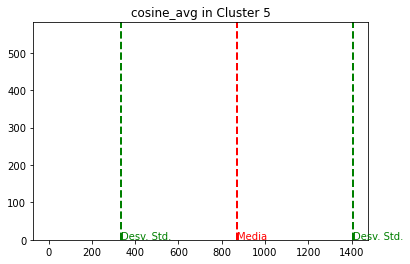






Cluster 6: 483 rows
Average number of tweets of a user being retweeted: 0.1222 ------> Standard deviation: 1.8116
Average number of emojis: 0.1222 ------> Standard deviation: 0.6438
User followers: 401.441 ------> Standard deviation: 2913.1756
User followed: 421.1905 ------> Standard deviation: 725.9548
Ratio favs_followers: 127.6565 ------> Standard deviation: 327.4455
Ratio retweets_followers: 0.0005 ------> Standard deviation: 0.0061
Average number of hashtags: 0.0228 ------> Standard deviation: 0.1972
Average number of tweets: 1.8613 ------> Standard deviation: 1.632
Average number of retweets: 0.234 ------> Standard deviation: 0.9229
Average number of languages: 1.0166 ------> Standard deviation: 0.1278
Ratio tweets by day: 1.8613 ------> Standard deviation: 1.632
Average number of emojis: 0.1222 ------> Standard deviation: 0.6438
Average number of mentions in each tweet: 1.7516 ------> Standard deviation: 1.0288
Average number of mentions by user: 3.4513 ------> Standard dev

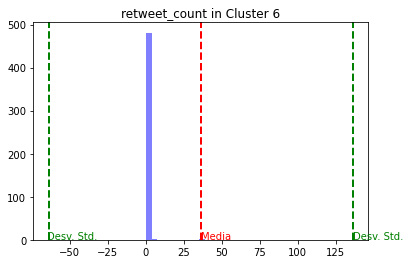

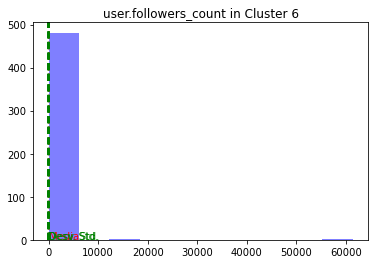

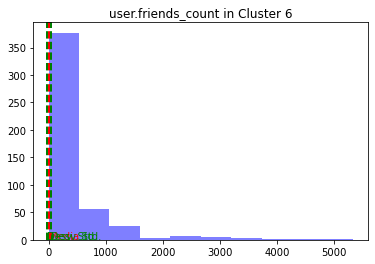

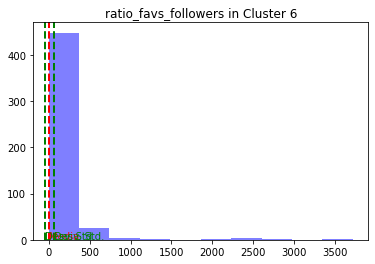

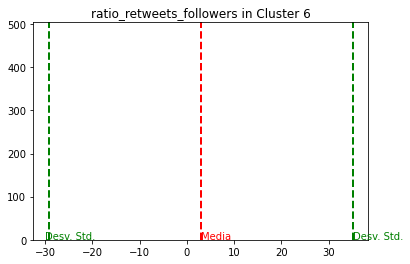

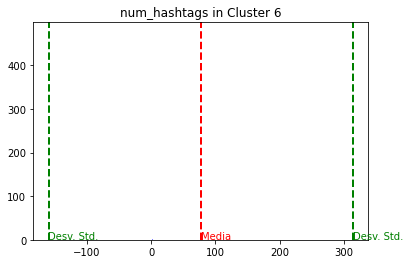

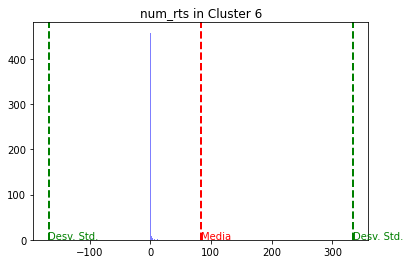

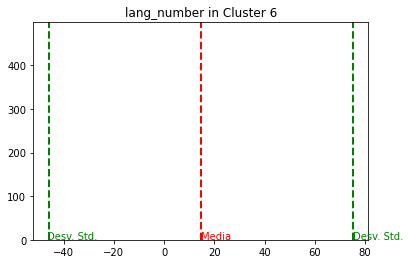

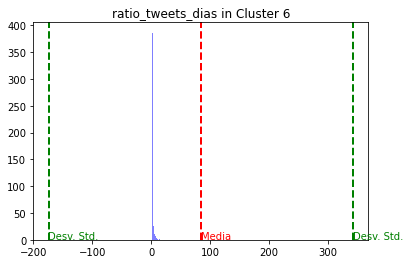

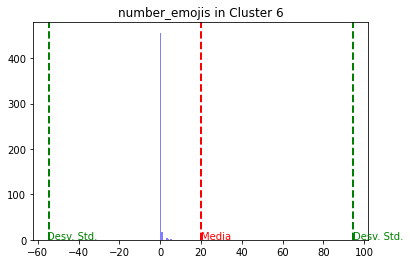

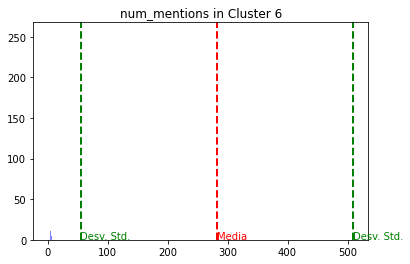

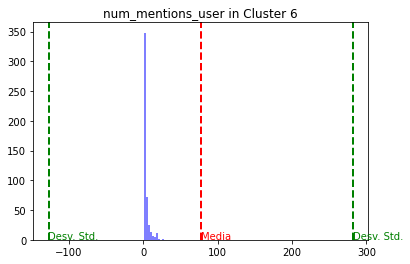

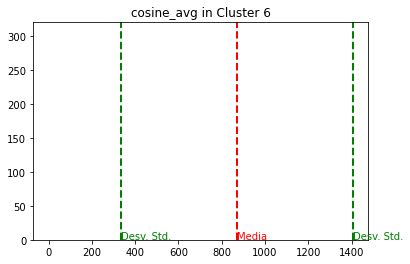






Cluster 7: 1849 rows
Average number of tweets of a user being retweeted: 2.3034 ------> Standard deviation: 15.1364
Average number of emojis: 0.1179 ------> Standard deviation: 0.5905
User followers: 103595.0108 ------> Standard deviation: 921423.5702
User followed: 2884.6236 ------> Standard deviation: 8087.1819
Ratio favs_followers: 39.9888 ------> Standard deviation: 156.5811
Ratio retweets_followers: 0.0004 ------> Standard deviation: 0.0027
Average number of hashtags: 0.4462 ------> Standard deviation: 1.0662
Average number of tweets: 3.1888 ------> Standard deviation: 4.7167
Average number of retweets: 0.3856 ------> Standard deviation: 1.8514
Average number of languages: 1.079 ------> Standard deviation: 0.3423
Ratio tweets by day: 3.1888 ------> Standard deviation: 4.7167
Average number of emojis: 0.1179 ------> Standard deviation: 0.5905
Average number of mentions in each tweet: 0.0654 ------> Standard deviation: 0.2743
Average number of mentions by user: 0.7729 ------> S

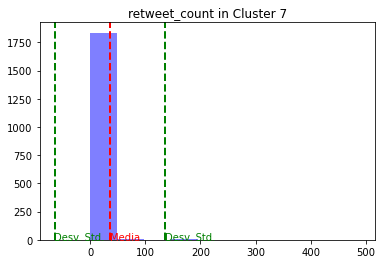

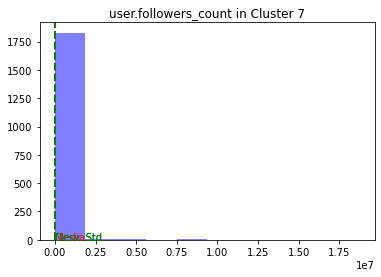

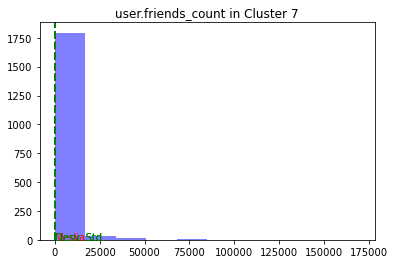

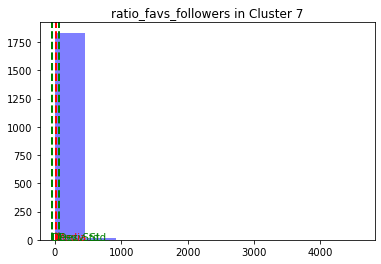

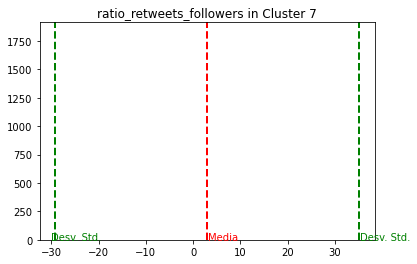

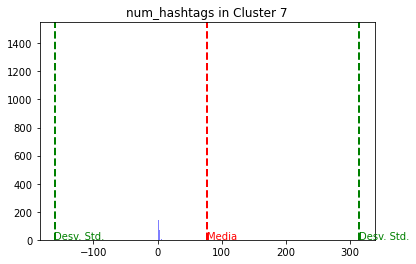

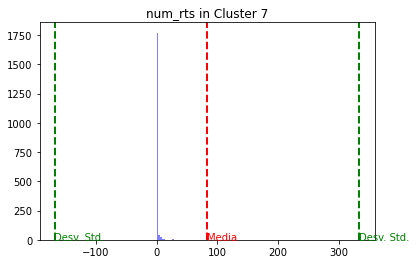

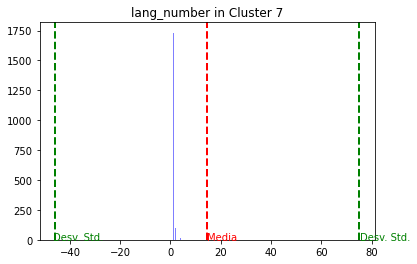

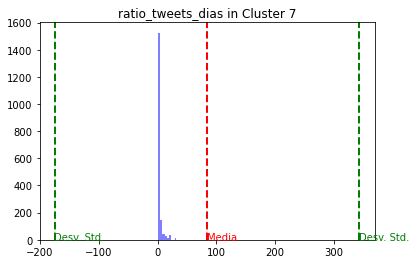

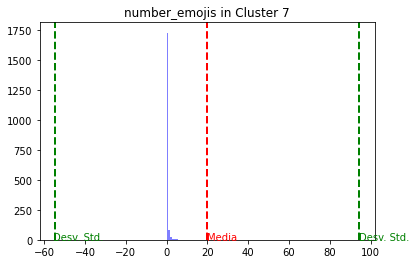

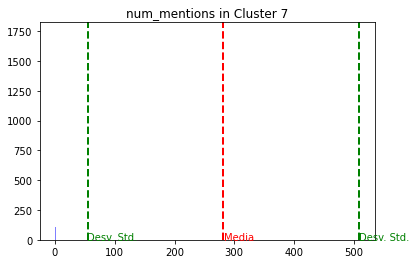

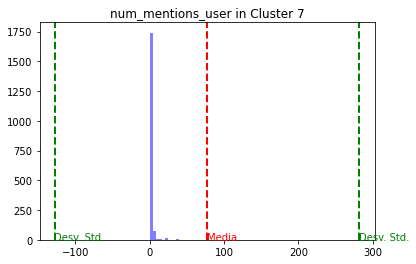

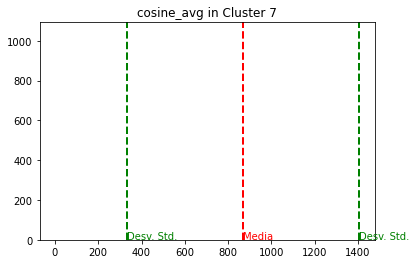






Cluster 8: 3463 rows
Average number of tweets of a user being retweeted: 878.0254 ------> Standard deviation: 1919.1264
Average number of emojis: 0.2405 ------> Standard deviation: 0.6938
User followers: 790.6904 ------> Standard deviation: 3333.3536
User followed: 995.1239 ------> Standard deviation: 1916.1448
Ratio favs_followers: 200.7068 ------> Standard deviation: 429.9153
Ratio retweets_followers: 49.4809 ------> Standard deviation: 238.2891
Average number of hashtags: 0.3003 ------> Standard deviation: 0.8129
Average number of tweets: 3.9249 ------> Standard deviation: 5.1465
Average number of retweets: 3.7551 ------> Standard deviation: 5.0458
Average number of languages: 1.1253 ------> Standard deviation: 0.3806
Ratio tweets by day: 3.9249 ------> Standard deviation: 5.1465
Average number of emojis: 0.2405 ------> Standard deviation: 0.6938
Average number of mentions in each tweet: 1.1764 ------> Standard deviation: 0.5142
Average number of mentions by user: 4.6102 ------

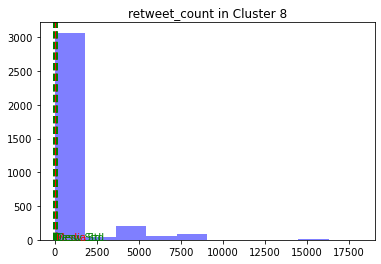

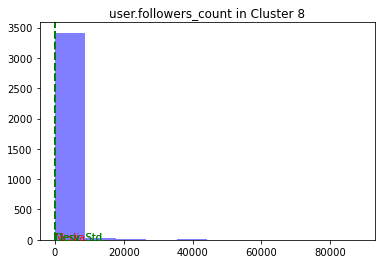

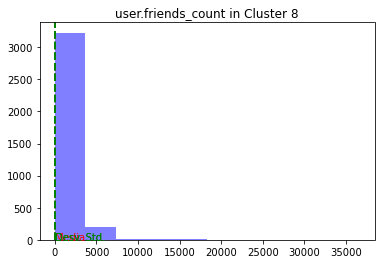

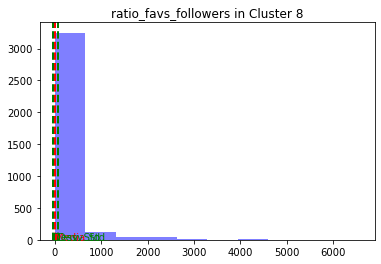

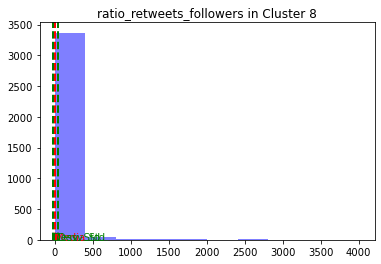

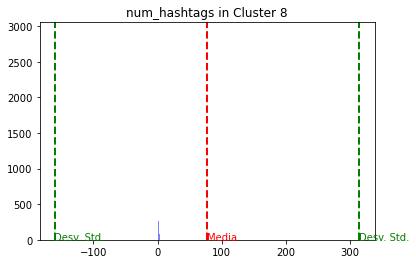

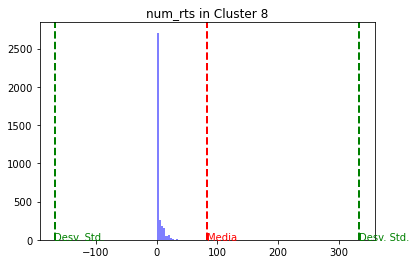

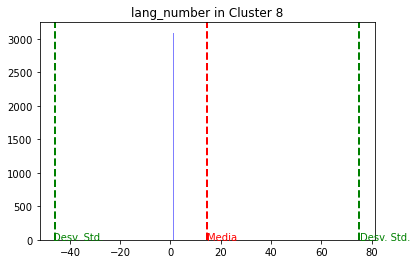

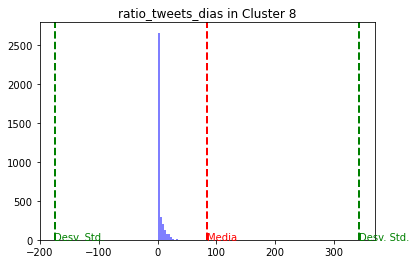

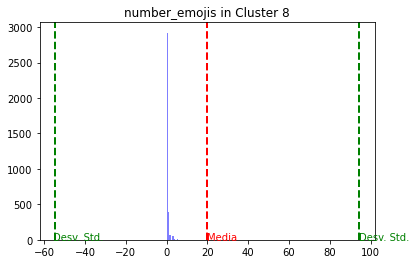

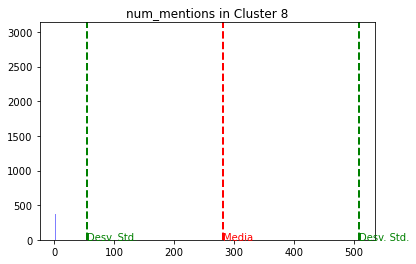

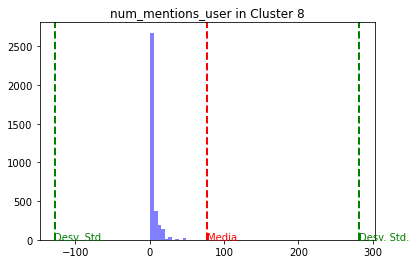

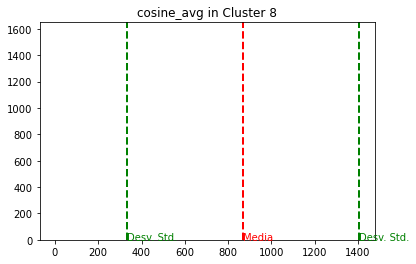






Cluster 9: 1037 rows
Average number of tweets of a user being retweeted: 851.4214 ------> Standard deviation: 1666.5544
Average number of emojis: 0.1533 ------> Standard deviation: 0.4879
User followers: 343.1022 ------> Standard deviation: 729.2097
User followed: 967.1254 ------> Standard deviation: 1428.4718
Ratio favs_followers: 456.2661 ------> Standard deviation: 502.152
Ratio retweets_followers: 29.102 ------> Standard deviation: 118.4106
Average number of hashtags: 0.2652 ------> Standard deviation: 0.7573
Average number of tweets: 4.7898 ------> Standard deviation: 6.393
Average number of retweets: 4.7329 ------> Standard deviation: 6.3414
Average number of languages: 1.161 ------> Standard deviation: 0.4284
Ratio tweets by day: 4.7898 ------> Standard deviation: 6.393
Average number of emojis: 0.1533 ------> Standard deviation: 0.4879
Average number of mentions in each tweet: 1.1379 ------> Standard deviation: 0.3871
Average number of mentions by user: 5.4233 ------> Stan

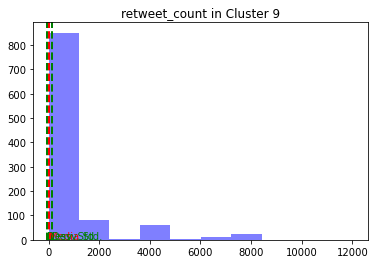

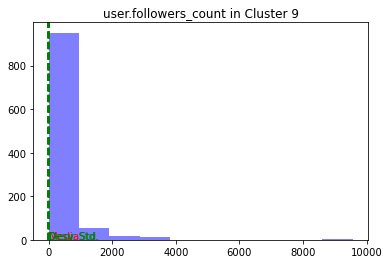

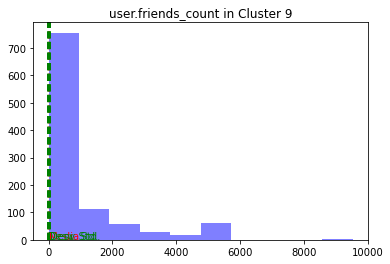

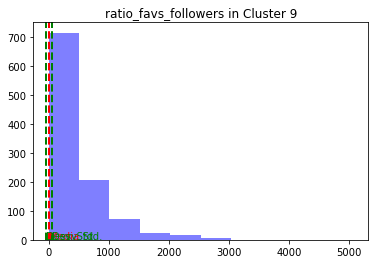

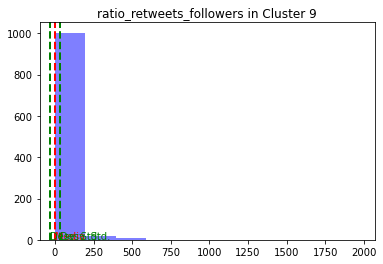

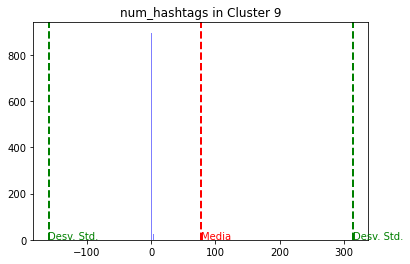

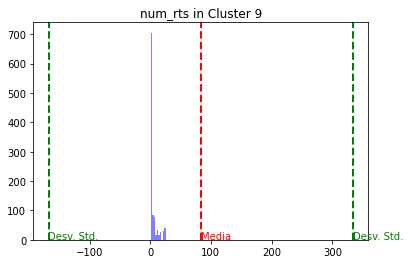

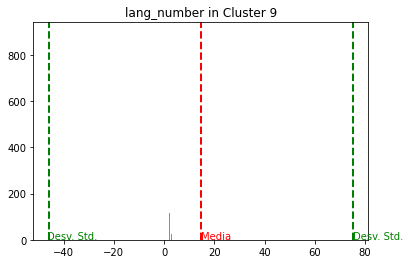

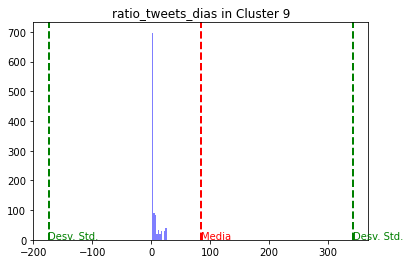

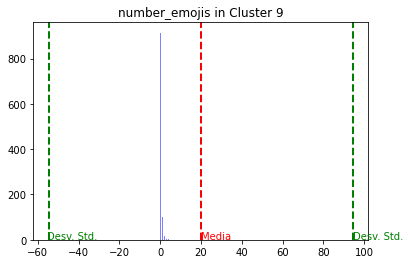

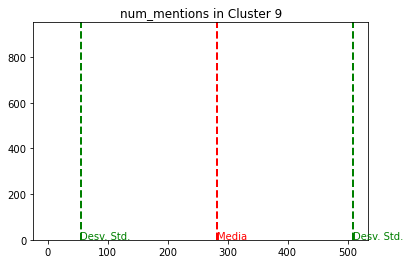

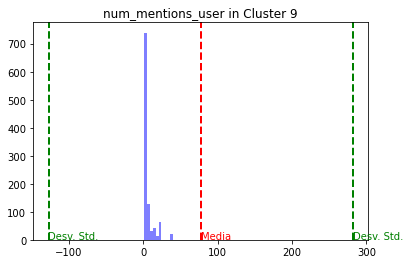

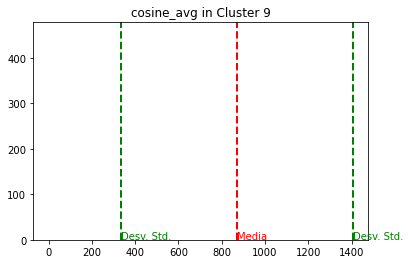






Cluster 10: 102 rows
Average number of tweets of a user being retweeted: 726.5294 ------> Standard deviation: 1466.8353
Average number of emojis: 0.2647 ------> Standard deviation: 0.5789
User followers: 179.7255 ------> Standard deviation: 472.3734
User followed: 365.7941 ------> Standard deviation: 655.6049
Ratio favs_followers: 491.4611 ------> Standard deviation: 598.8872
Ratio retweets_followers: 75.9506 ------> Standard deviation: 262.3889
Average number of hashtags: 0.1471 ------> Standard deviation: 0.4955
Average number of tweets: 4.8627 ------> Standard deviation: 5.2822
Average number of retweets: 4.7941 ------> Standard deviation: 5.2338
Average number of languages: 1.0686 ------> Standard deviation: 0.2541
Ratio tweets by day: 4.8627 ------> Standard deviation: 5.2822
Average number of emojis: 0.2647 ------> Standard deviation: 0.5789
Average number of mentions in each tweet: 1.1373 ------> Standard deviation: 0.399
Average number of mentions by user: 5.3529 ------> S

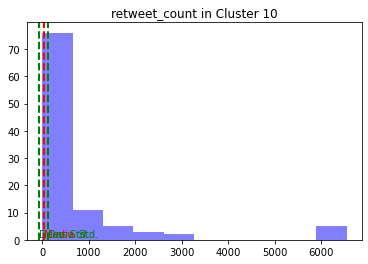

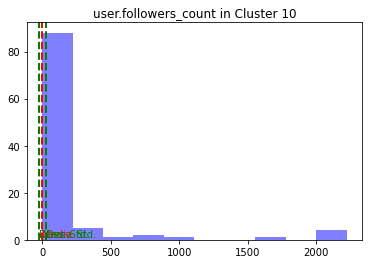

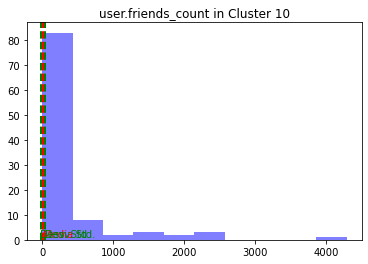

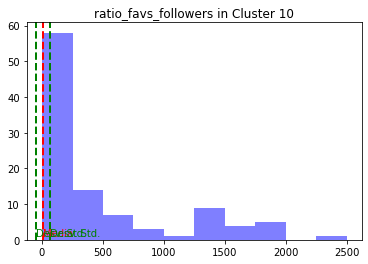

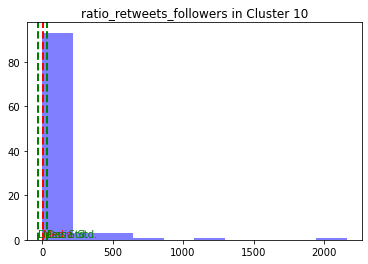

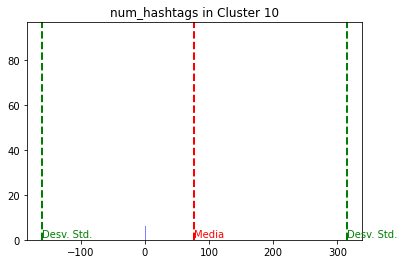

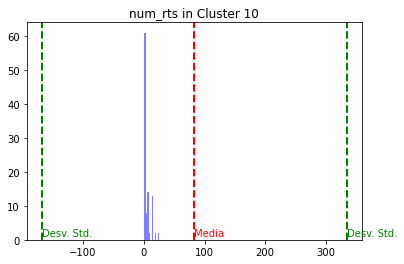

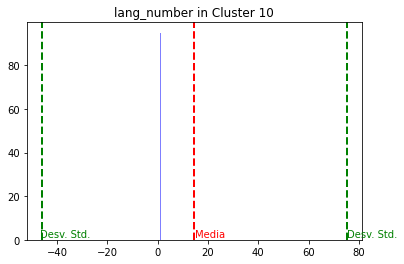

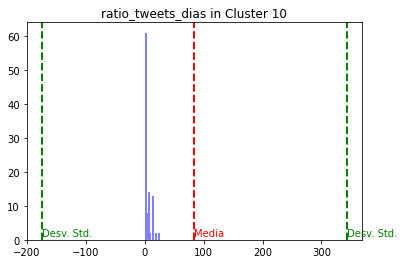

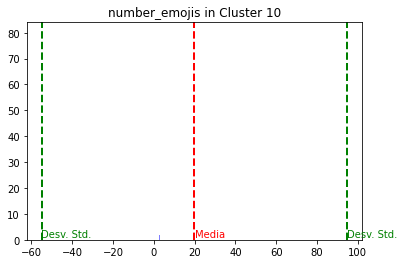

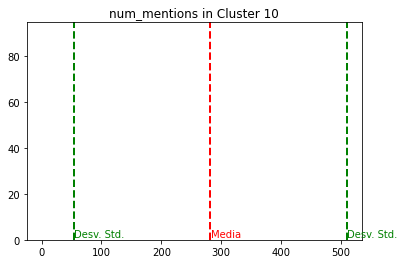

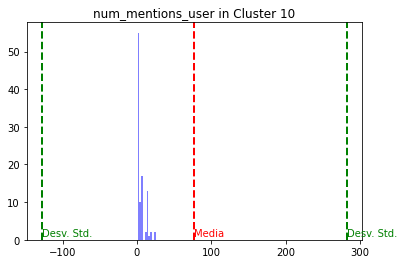

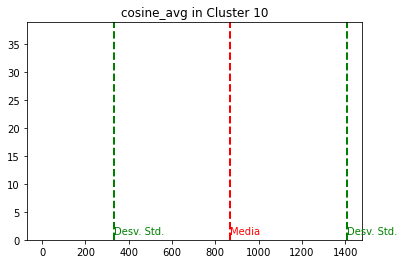






Cluster 11: 1269 rows
Average number of tweets of a user being retweeted: 0.1072 ------> Standard deviation: 1.2488
Average number of emojis: 0.0906 ------> Standard deviation: 0.4481
User followers: 441.4681 ------> Standard deviation: 3277.528
User followed: 484.9283 ------> Standard deviation: 1494.6356
Ratio favs_followers: 126.5621 ------> Standard deviation: 412.3649
Ratio retweets_followers: 0.0014 ------> Standard deviation: 0.0164
Average number of hashtags: 0.0583 ------> Standard deviation: 0.3701
Average number of tweets: 2.0559 ------> Standard deviation: 1.9316
Average number of retweets: 0.264 ------> Standard deviation: 1.1087
Average number of languages: 1.0213 ------> Standard deviation: 0.1497
Ratio tweets by day: 2.0559 ------> Standard deviation: 1.9316
Average number of emojis: 0.0906 ------> Standard deviation: 0.4481
Average number of mentions in each tweet: 2.0236 ------> Standard deviation: 1.4246
Average number of mentions by user: 4.1931 ------> Standar

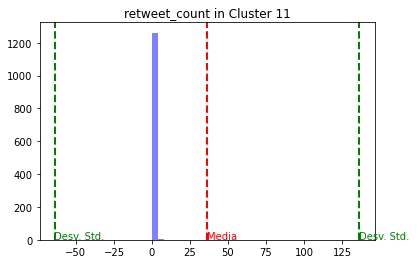

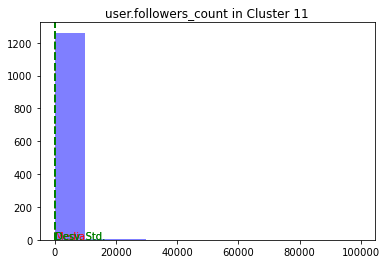

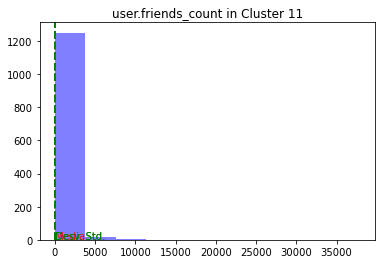

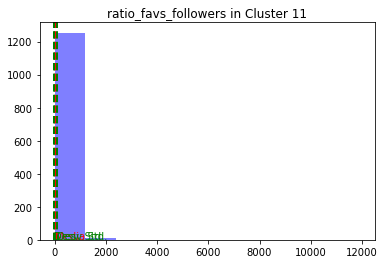

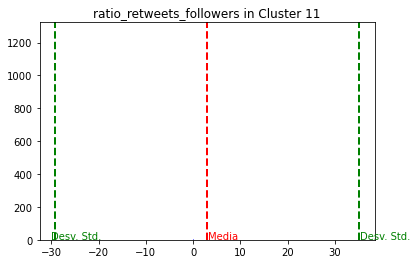

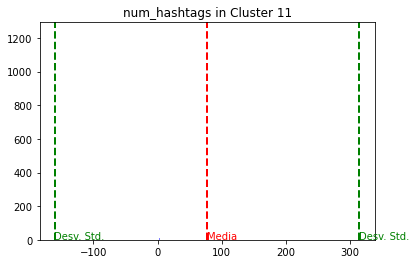

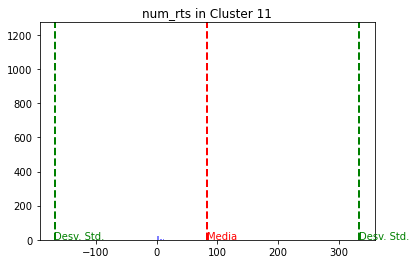

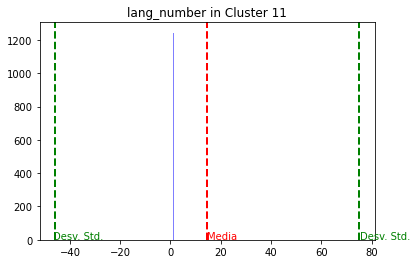

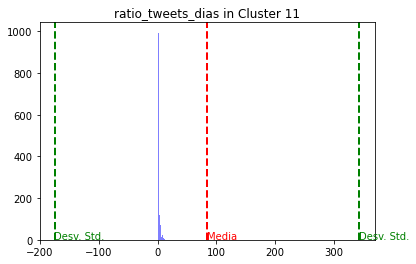

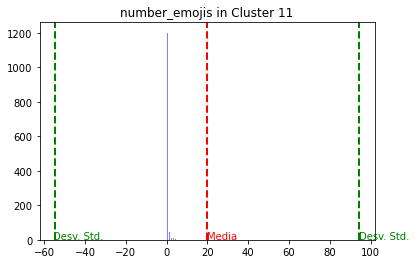

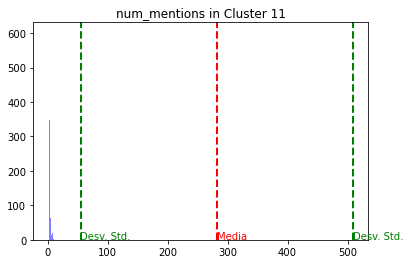

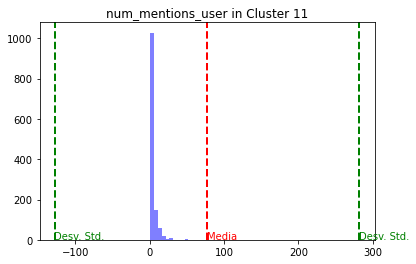

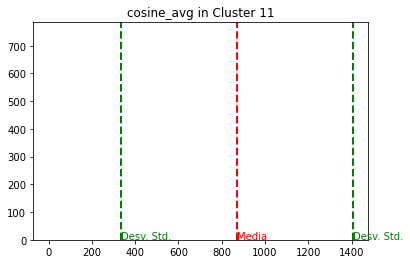






Cluster 12: 211 rows
Average number of tweets of a user being retweeted: 0.0142 ------> Standard deviation: 0.1536
Average number of emojis: 0.0569 ------> Standard deviation: 0.5828
User followers: 123.8152 ------> Standard deviation: 410.9301
User followed: 342.1232 ------> Standard deviation: 772.5281
Ratio favs_followers: 209.1023 ------> Standard deviation: 292.111
Ratio retweets_followers: 0.0048 ------> Standard deviation: 0.0688
Average number of hashtags: 0.0095 ------> Standard deviation: 0.0971
Average number of tweets: 1.6635 ------> Standard deviation: 1.1022
Average number of retweets: 0.0711 ------> Standard deviation: 0.4361
Average number of languages: 1.0142 ------> Standard deviation: 0.1187
Ratio tweets by day: 1.6635 ------> Standard deviation: 1.1022
Average number of emojis: 0.0569 ------> Standard deviation: 0.5828
Average number of mentions in each tweet: 1.782 ------> Standard deviation: 1.1629
Average number of mentions by user: 2.9526 ------> Standard d

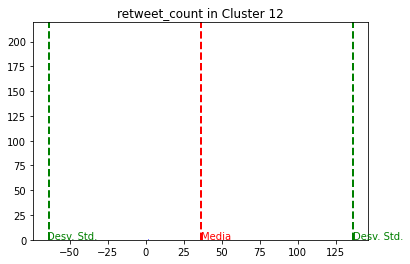

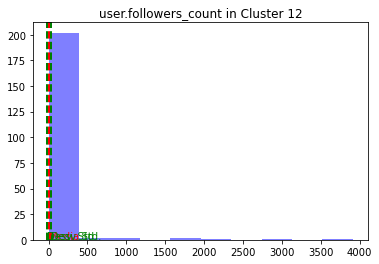

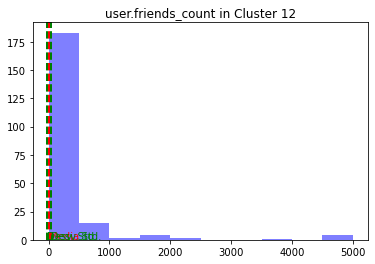

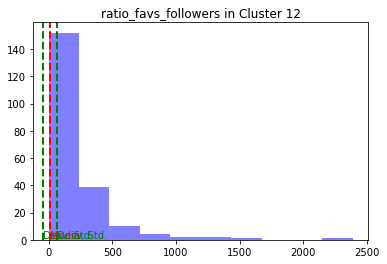

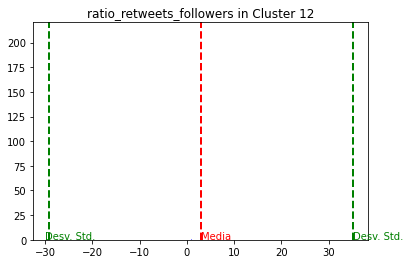

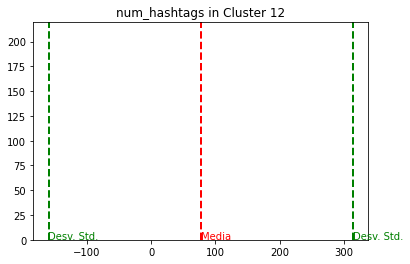

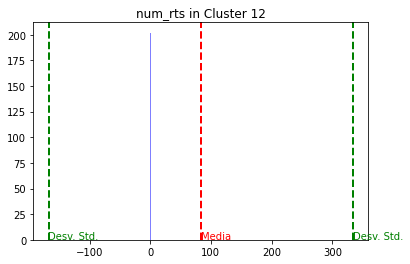

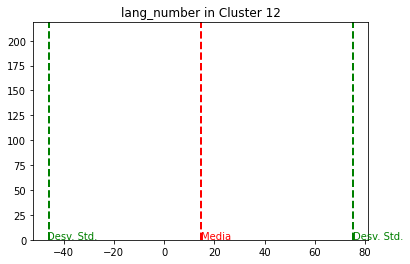

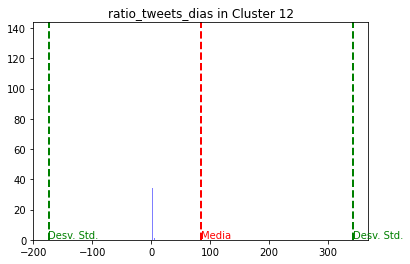

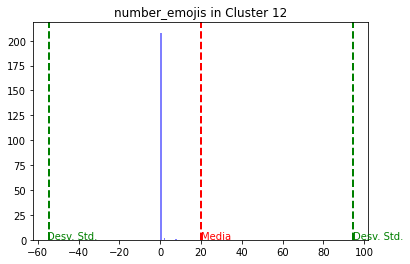

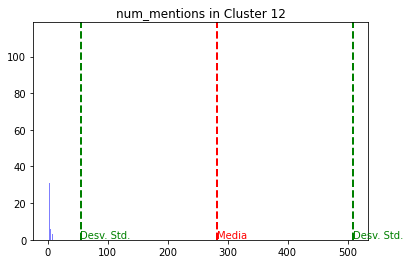

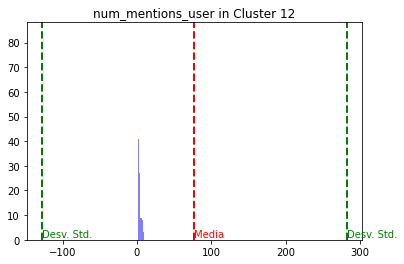

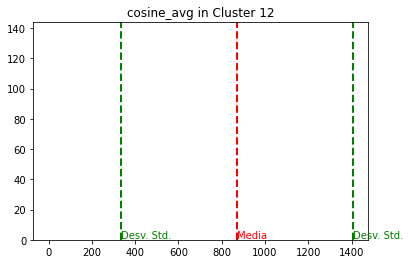






Cluster 13: 336 rows
Average number of tweets of a user being retweeted: 1249.7738 ------> Standard deviation: 2142.0221
Average number of emojis: 0.1994 ------> Standard deviation: 0.5926
User followers: 166.9494 ------> Standard deviation: 456.5078
User followed: 361.5417 ------> Standard deviation: 558.5567
Ratio favs_followers: 398.1231 ------> Standard deviation: 589.1221
Ratio retweets_followers: 145.4886 ------> Standard deviation: 500.2467
Average number of hashtags: 0.256 ------> Standard deviation: 0.7123
Average number of tweets: 5.5833 ------> Standard deviation: 6.9294
Average number of retweets: 5.5149 ------> Standard deviation: 6.9044
Average number of languages: 1.0714 ------> Standard deviation: 0.2801
Ratio tweets by day: 5.5833 ------> Standard deviation: 6.9294
Average number of emojis: 0.1994 ------> Standard deviation: 0.5926
Average number of mentions in each tweet: 1.1845 ------> Standard deviation: 0.4457
Average number of mentions by user: 6.0804 ------>

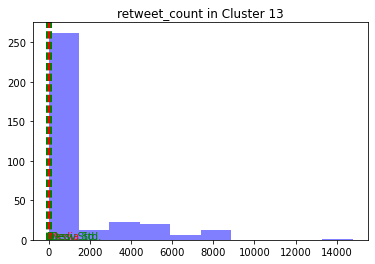

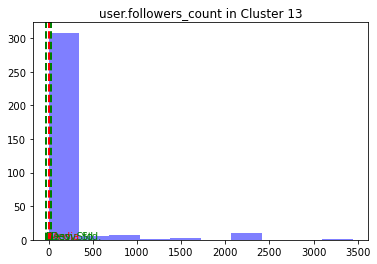

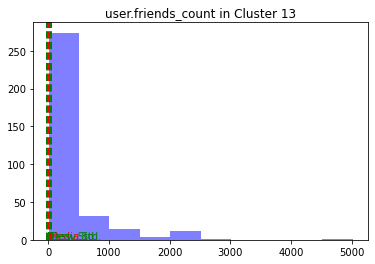

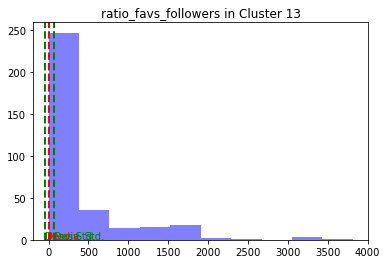

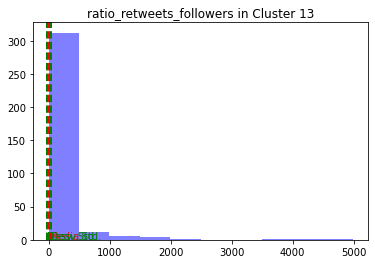

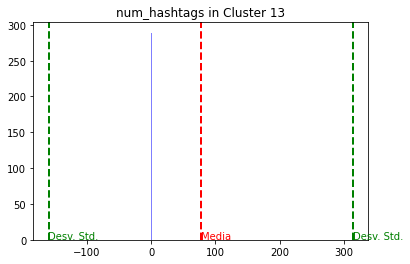

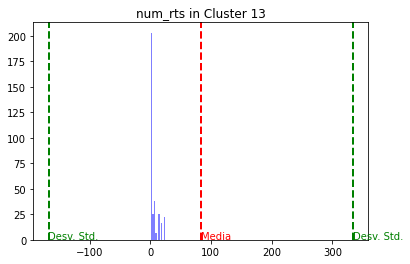

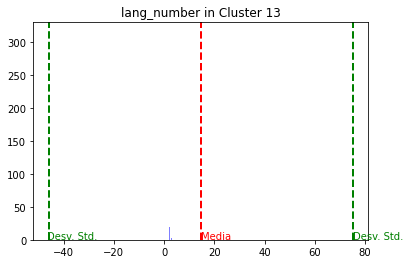

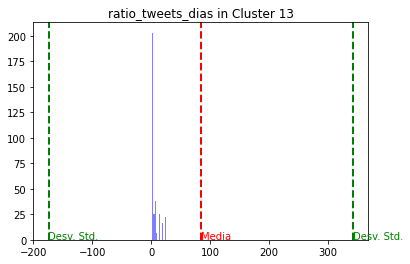

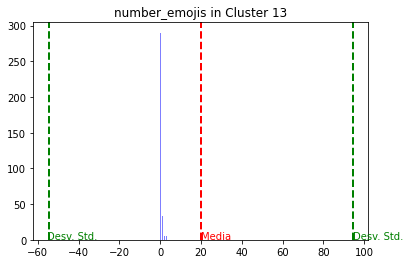

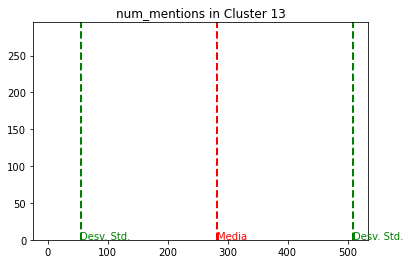

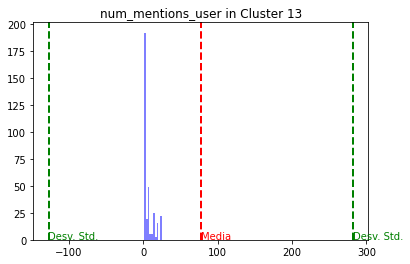

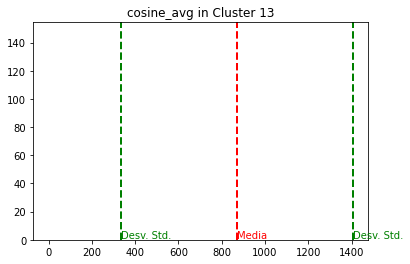






Cluster 14: 406 rows
Average number of tweets of a user being retweeted: 812.1502 ------> Standard deviation: 1289.871
Average number of emojis: 0.2167 ------> Standard deviation: 0.509
User followers: 319.9606 ------> Standard deviation: 599.948
User followed: 921.7759 ------> Standard deviation: 1367.8869
Ratio favs_followers: 532.1059 ------> Standard deviation: 664.944
Ratio retweets_followers: 29.7055 ------> Standard deviation: 108.6873
Average number of hashtags: 0.202 ------> Standard deviation: 0.5868
Average number of tweets: 4.5099 ------> Standard deviation: 5.9291
Average number of retweets: 4.4581 ------> Standard deviation: 5.8859
Average number of languages: 1.1527 ------> Standard deviation: 0.3992
Ratio tweets by day: 4.5099 ------> Standard deviation: 5.9291
Average number of emojis: 0.2167 ------> Standard deviation: 0.509
Average number of mentions in each tweet: 1.1675 ------> Standard deviation: 0.5131
Average number of mentions by user: 5.0665 ------> Stand

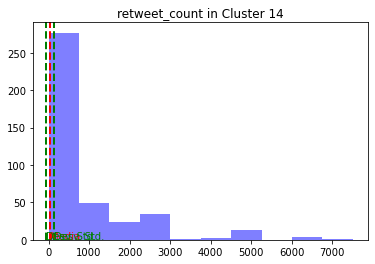

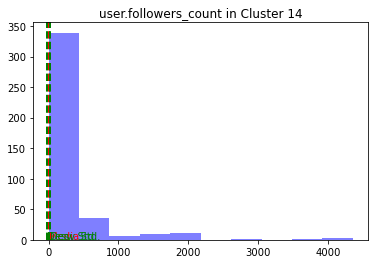

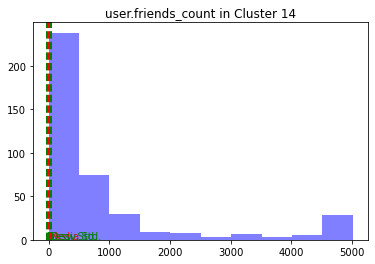

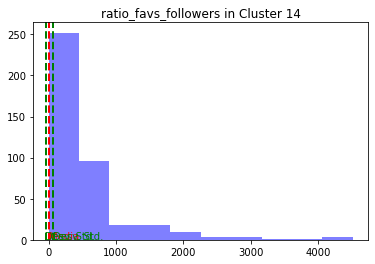

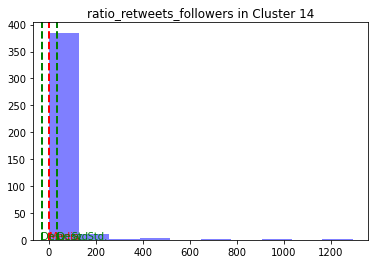

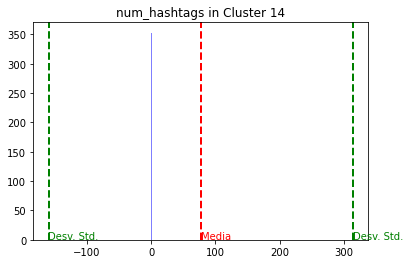

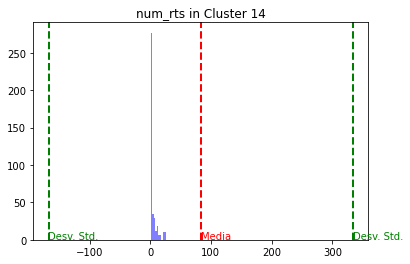

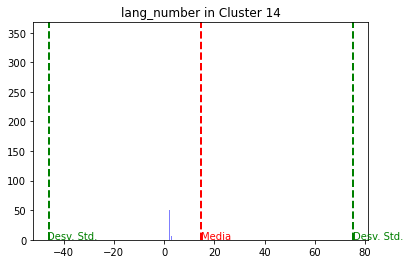

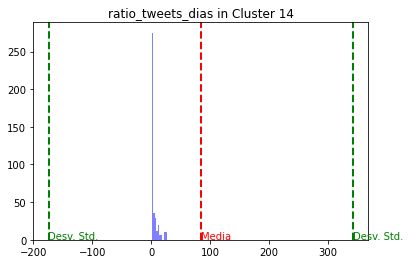

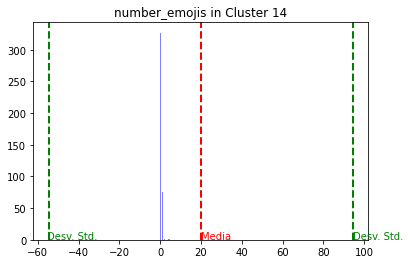

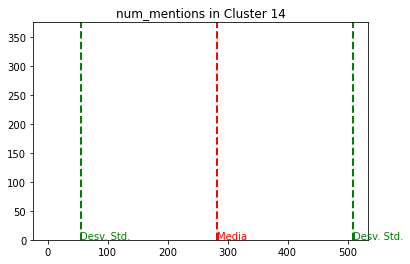

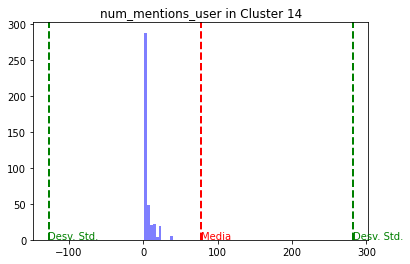

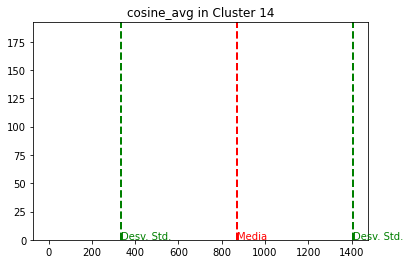






Cluster 15: 213 rows
Average number of tweets of a user being retweeted: 1.77 ------> Standard deviation: 12.9527
Average number of emojis: 0.2535 ------> Standard deviation: 0.784
User followers: 2497.9718 ------> Standard deviation: 10621.2239
User followed: 693.7042 ------> Standard deviation: 2768.1312
Ratio favs_followers: 28.3078 ------> Standard deviation: 52.2677
Ratio retweets_followers: 0.0377 ------> Standard deviation: 0.2608
Average number of hashtags: 0.4319 ------> Standard deviation: 0.8695
Average number of tweets: 4.0423 ------> Standard deviation: 5.762
Average number of retweets: 0.1502 ------> Standard deviation: 0.5009
Average number of languages: 1.1315 ------> Standard deviation: 0.3904
Ratio tweets by day: 4.0423 ------> Standard deviation: 5.762
Average number of emojis: 0.2535 ------> Standard deviation: 0.784
Average number of mentions in each tweet: 0.0282 ------> Standard deviation: 0.1658
Average number of mentions by user: 0.3709 ------> Standard de

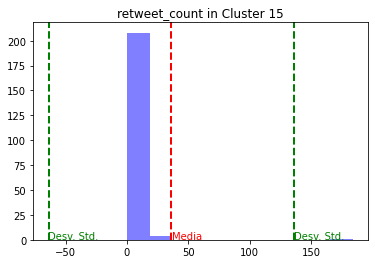

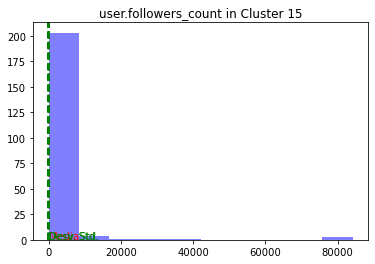

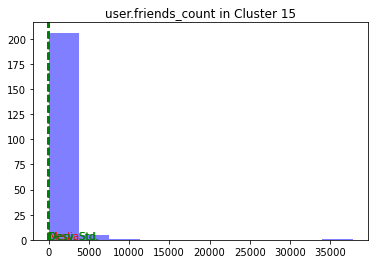

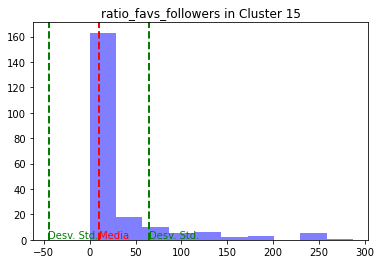

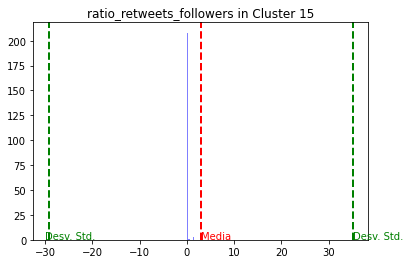

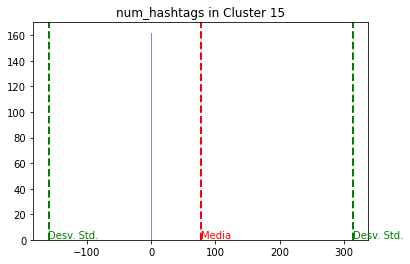

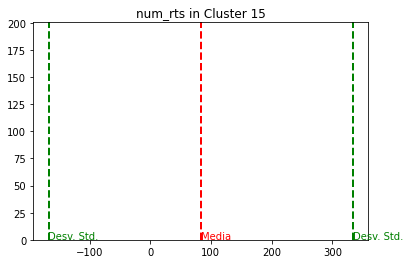

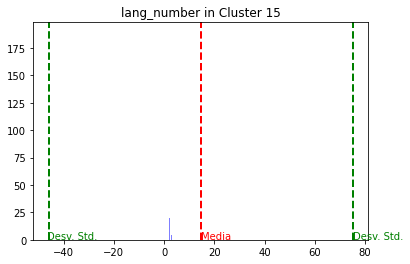

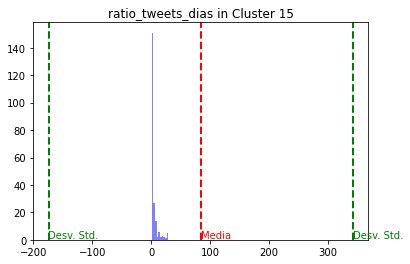

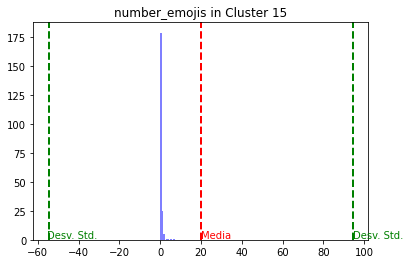

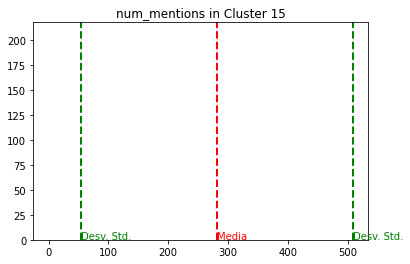

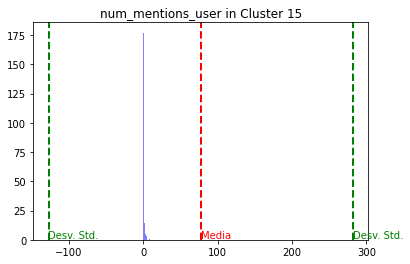

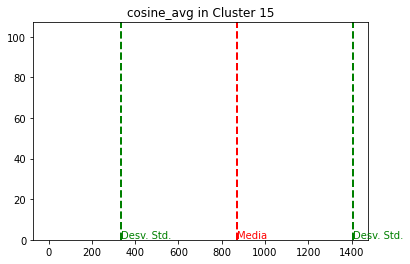






Cluster 16: 722 rows
Average number of tweets of a user being retweeted: 0.7881 ------> Standard deviation: 4.5246
Average number of emojis: 0.1537 ------> Standard deviation: 0.6096
User followers: 1832.5374 ------> Standard deviation: 8338.399
User followed: 689.0 ------> Standard deviation: 2295.3131
Ratio favs_followers: 25.3877 ------> Standard deviation: 82.6913
Ratio retweets_followers: 0.0042 ------> Standard deviation: 0.0452
Average number of hashtags: 1.2659 ------> Standard deviation: 1.8662
Average number of tweets: 9.8255 ------> Standard deviation: 12.3819
Average number of retweets: 0.126 ------> Standard deviation: 0.7101
Average number of languages: 1.4086 ------> Standard deviation: 0.7245
Ratio tweets by day: 9.8255 ------> Standard deviation: 12.3819
Average number of emojis: 0.1537 ------> Standard deviation: 0.6096
Average number of mentions in each tweet: 0.0346 ------> Standard deviation: 0.183
Average number of mentions by user: 0.3781 ------> Standard de

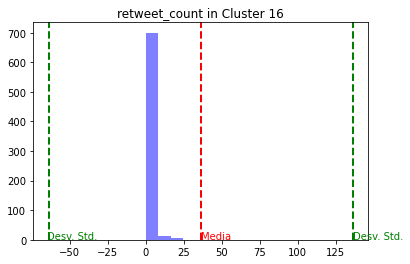

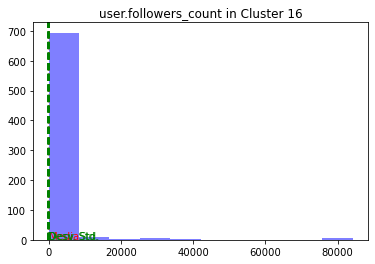

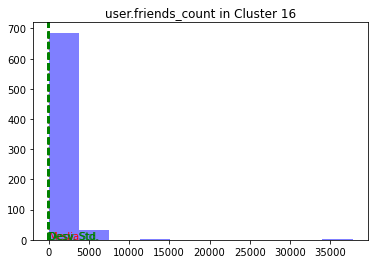

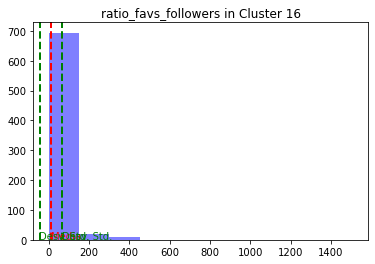

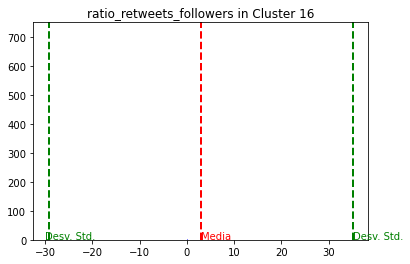

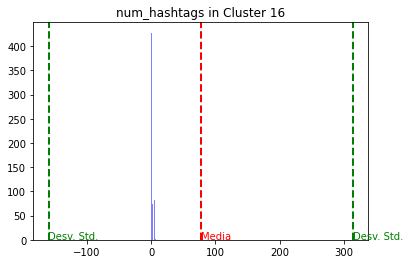

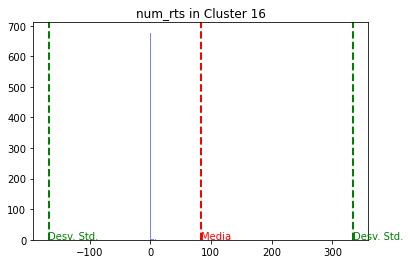

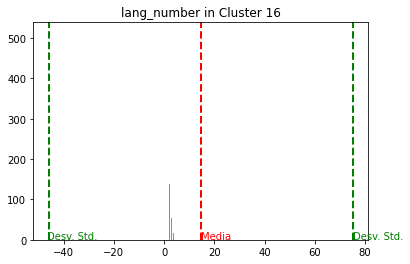

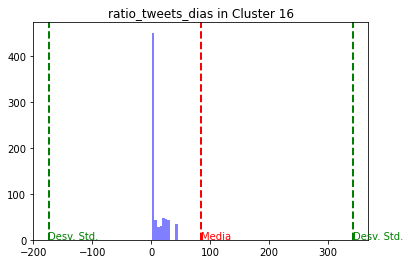

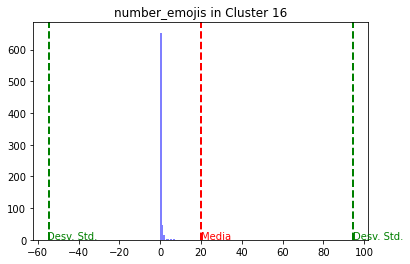

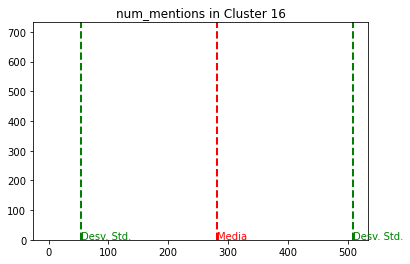

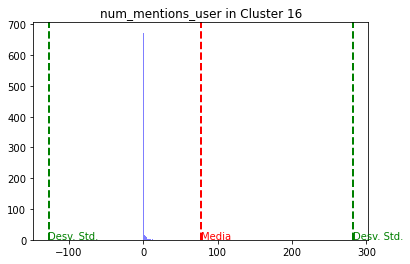

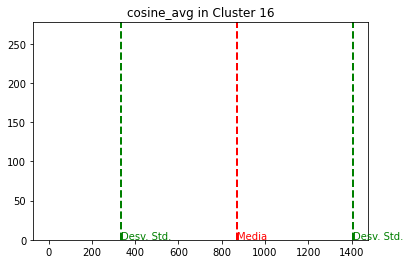






Cluster 17: 98 rows
Average number of tweets of a user being retweeted: 0.0612 ------> Standard deviation: 0.241
Average number of emojis: 0.102 ------> Standard deviation: 0.4867
User followers: 55.7755 ------> Standard deviation: 228.956
User followed: 183.3776 ------> Standard deviation: 404.1811
Ratio favs_followers: 225.3598 ------> Standard deviation: 550.0338
Ratio retweets_followers: 0.0179 ------> Standard deviation: 0.114
Average number of hashtags: 0.0102 ------> Standard deviation: 0.101
Average number of tweets: 1.7551 ------> Standard deviation: 2.2842
Average number of retweets: 0.2449 ------> Standard deviation: 1.4577
Average number of languages: 1.0204 ------> Standard deviation: 0.1421
Ratio tweets by day: 1.7551 ------> Standard deviation: 2.2842
Average number of emojis: 0.102 ------> Standard deviation: 0.4867
Average number of mentions in each tweet: 1.7347 ------> Standard deviation: 1.0108
Average number of mentions by user: 3.0408 ------> Standard deviati

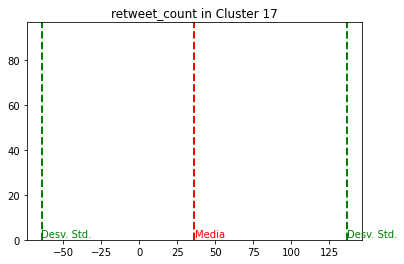

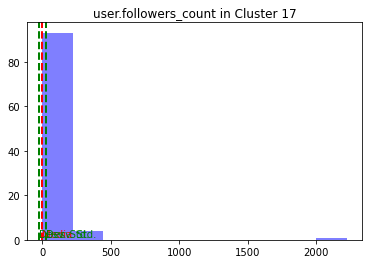

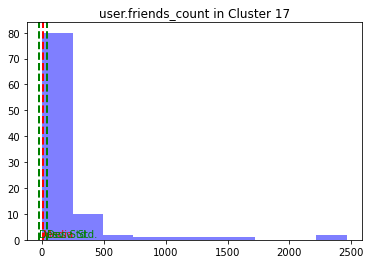

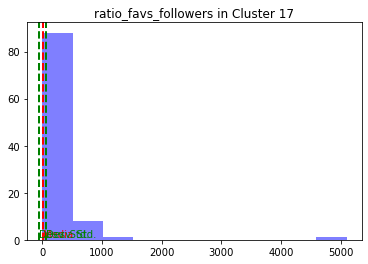

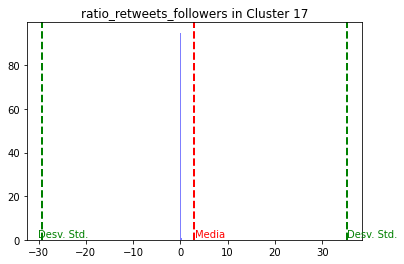

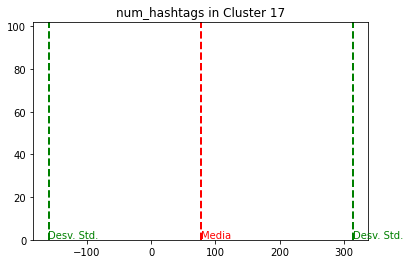

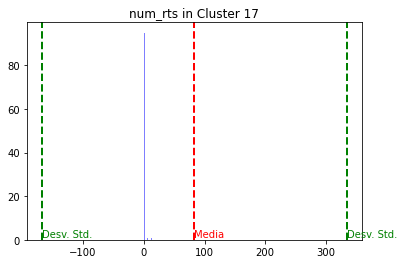

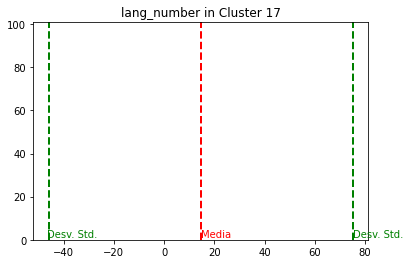

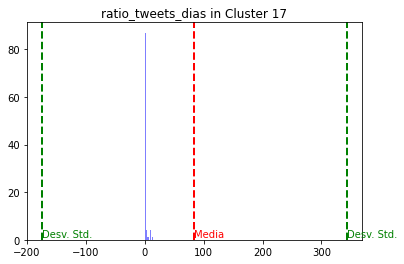

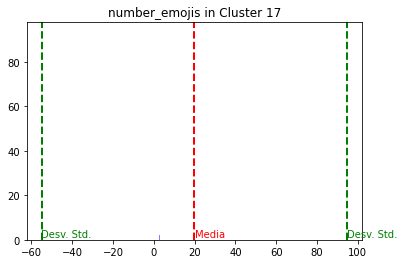

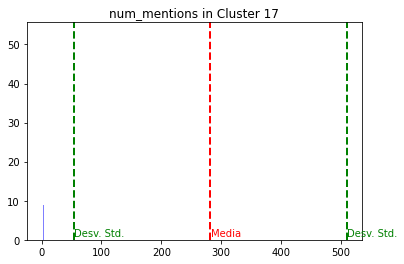

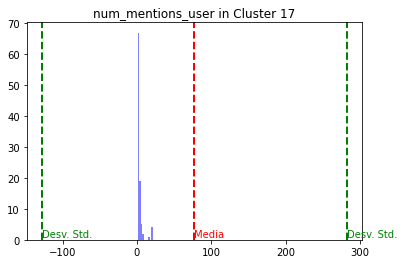

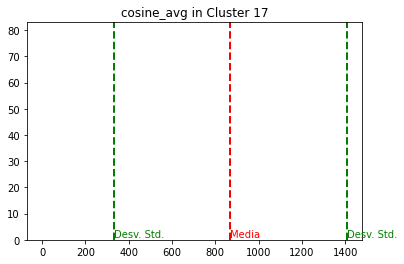






Cluster 18: 81 rows
Average number of tweets of a user being retweeted: 0.0741 ------> Standard deviation: 0.4684
Average number of emojis: 0.0494 ------> Standard deviation: 0.35
User followers: 36.9506 ------> Standard deviation: 85.7901
User followed: 220.7037 ------> Standard deviation: 325.0905
Ratio favs_followers: 271.4739 ------> Standard deviation: 372.4681
Ratio retweets_followers: 0.0021 ------> Standard deviation: 0.0161
Average number of hashtags: 0.0 ------> Standard deviation: 0.0
Average number of tweets: 1.2593 ------> Standard deviation: 0.5191
Average number of retweets: 0.0247 ------> Standard deviation: 0.1561
Average number of languages: 1.0 ------> Standard deviation: 0.0
Ratio tweets by day: 1.2593 ------> Standard deviation: 0.5191
Average number of emojis: 0.0494 ------> Standard deviation: 0.35
Average number of mentions in each tweet: 1.6049 ------> Standard deviation: 0.8899
Average number of mentions by user: 1.9012 ------> Standard deviation: 1.0678


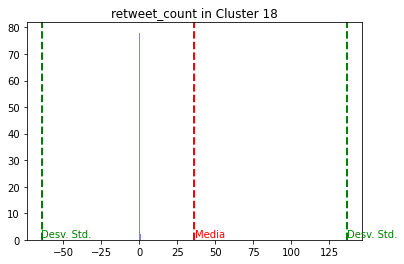

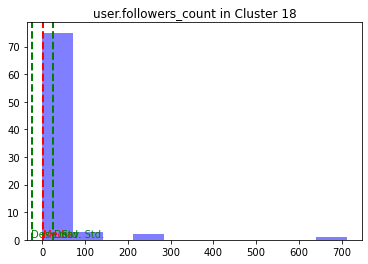

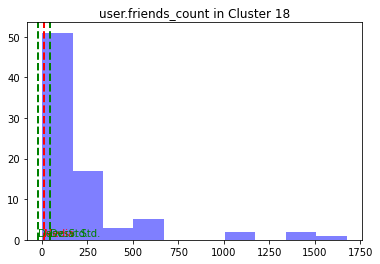

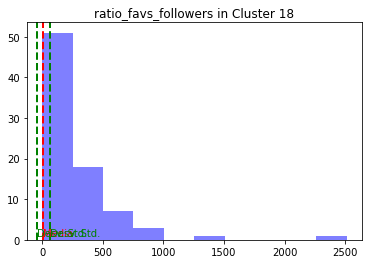

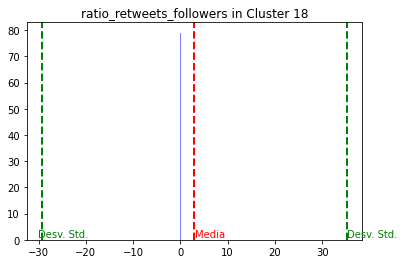

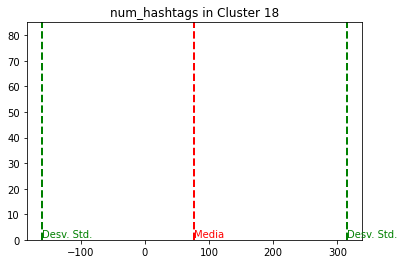

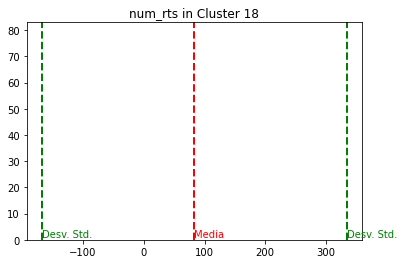

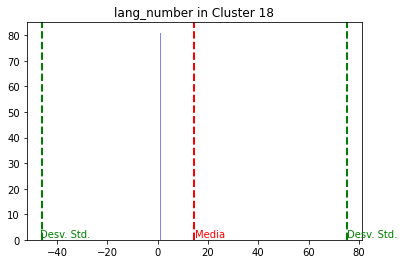

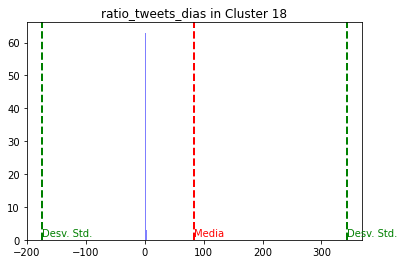

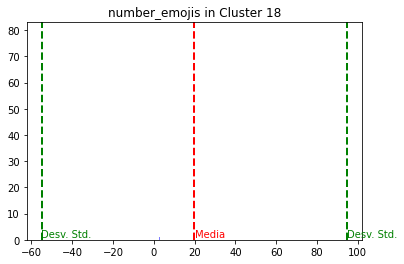

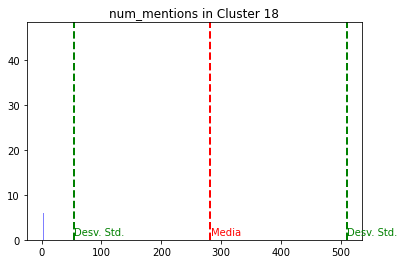

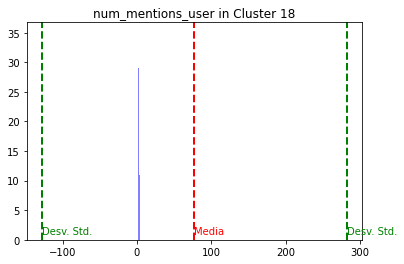

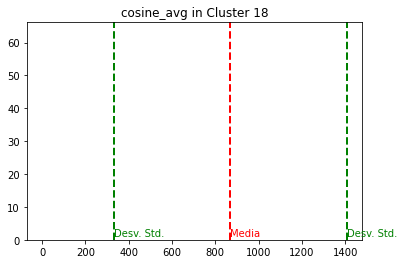






Cluster 19: 62 rows
Average number of tweets of a user being retweeted: 177.8226 ------> Standard deviation: 274.8701
Average number of emojis: 0.2258 ------> Standard deviation: 0.4932
User followers: 642.2097 ------> Standard deviation: 0.4104
User followed: 982.0 ------> Standard deviation: 0.0
Ratio favs_followers: 204.7091 ------> Standard deviation: 0.2275
Ratio retweets_followers: 0.2769 ------> Standard deviation: 0.4279
Average number of hashtags: 0.3065 ------> Standard deviation: 0.8216
Average number of tweets: 93.0 ------> Standard deviation: 0.0
Average number of retweets: 90.0 ------> Standard deviation: 0.0
Average number of languages: 2.0 ------> Standard deviation: 0.0
Ratio tweets by day: 93.0 ------> Standard deviation: 0.0
Average number of emojis: 0.2258 ------> Standard deviation: 0.4932
Average number of mentions in each tweet: 1.0323 ------> Standard deviation: 0.1781
Average number of mentions by user: 93.0 ------> Standard deviation: 0.0
Average number o

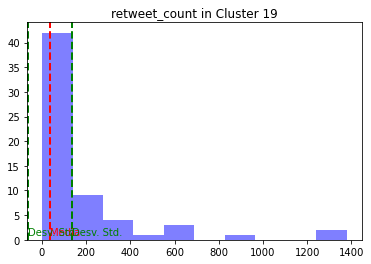

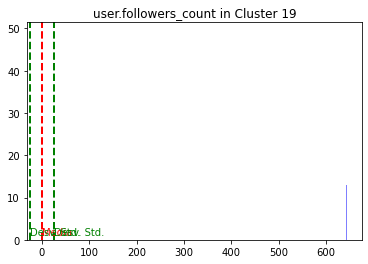

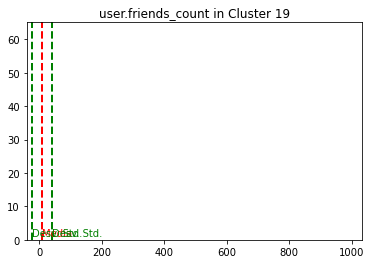

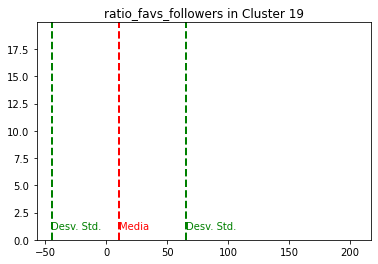

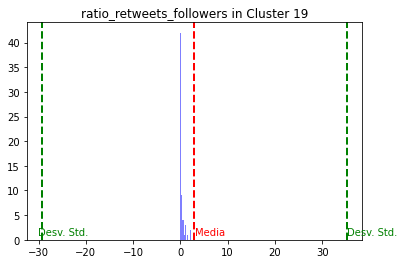

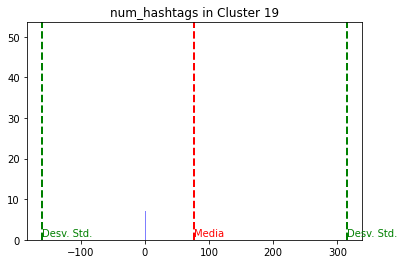

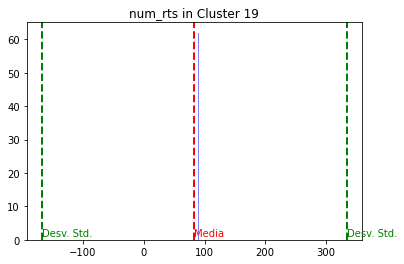

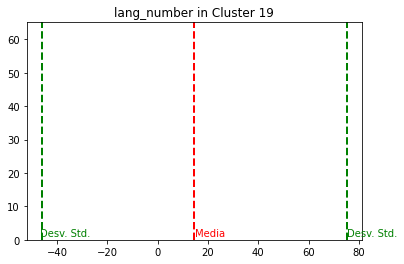

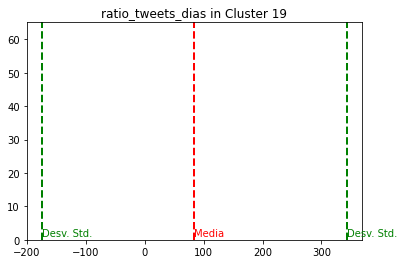

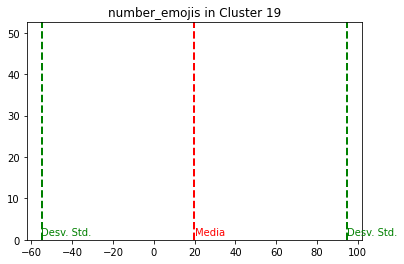

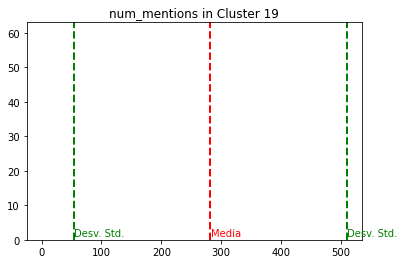

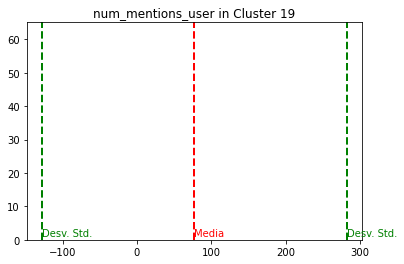

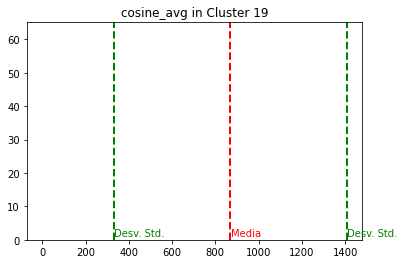






Cluster 20: 106 rows
Average number of tweets of a user being retweeted: 363.2642 ------> Standard deviation: 199.2191
Average number of emojis: 0.0 ------> Standard deviation: 0.0
User followers: 132.0 ------> Standard deviation: 0.0
User followed: 26.0 ------> Standard deviation: 0.0
Ratio favs_followers: 0.0 ------> Standard deviation: 0.0
Ratio retweets_followers: 2.752 ------> Standard deviation: 1.5092
Average number of hashtags: 1.283 ------> Standard deviation: 0.4732
Average number of tweets: 150.0 ------> Standard deviation: 0.0
Average number of retweets: 150.0 ------> Standard deviation: 0.0
Average number of languages: 1.0 ------> Standard deviation: 0.0
Ratio tweets by day: 150.0 ------> Standard deviation: 0.0
Average number of emojis: 0.0 ------> Standard deviation: 0.0
Average number of mentions in each tweet: 1.0 ------> Standard deviation: 0.0
Average number of mentions by user: 150.0 ------> Standard deviation: 0.0
Average number of cosine similarity by user tw

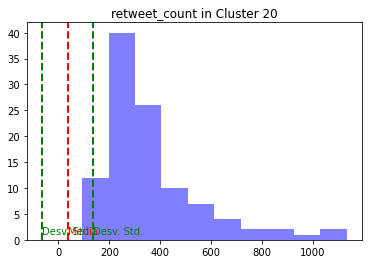

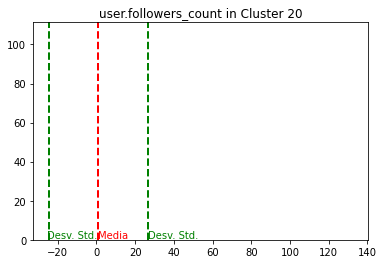

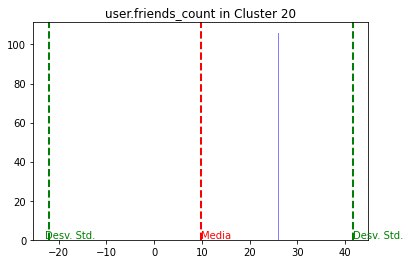

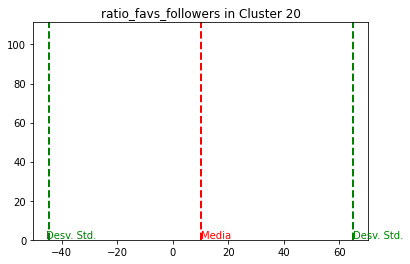

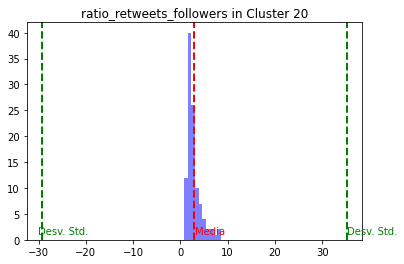

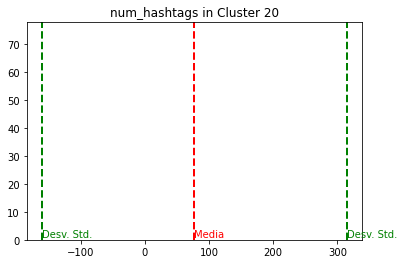

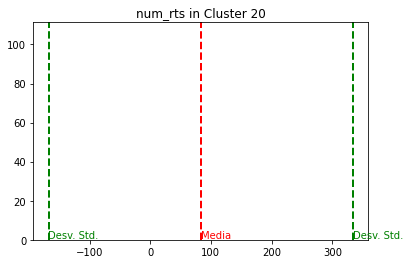

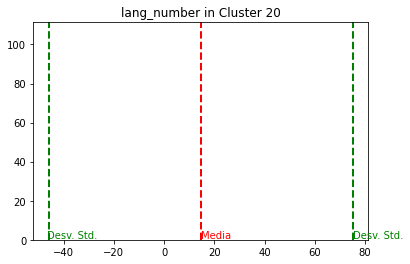

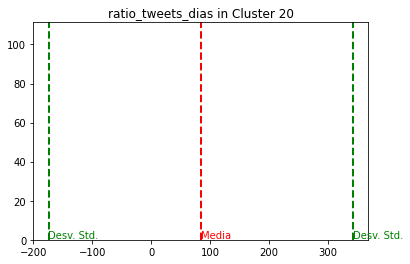

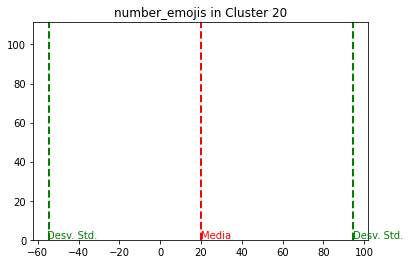

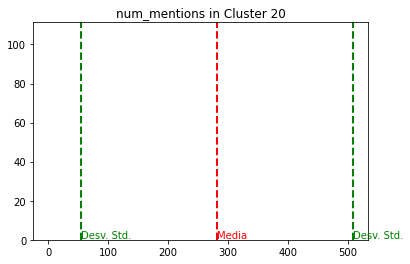

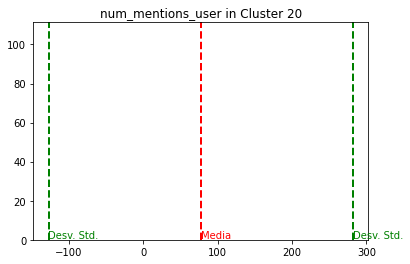

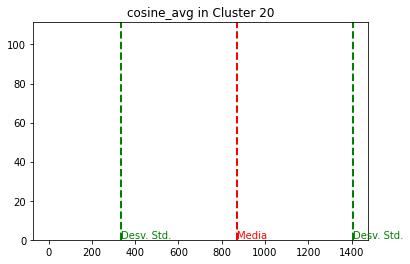

In [27]:
import matplotlib.pyplot as plt
#Desviación típica
#Diagrama de distribución para cada métrica

for name, group in groups:
    
    lista_cols_interes = ['retweet_count', 'user.followers_count', 'user.friends_count', 'ratio_favs_followers',
                         'ratio_retweets_followers', 'num_hashtags', 'num_rts', 'lang_number', 'ratio_tweets_dias', 'number_emojis',
                         'num_mentions', 'num_mentions_user', 'cosine_avg']
    
    print("\n")
    print(f"Cluster {name}: {len(group)} rows")
    print(f"Average number of tweets of a user being retweeted: {round(group['retweet_count'].mean(),4)} ------> Standard deviation: {round(group['retweet_count'].std(),4)}")
    print(f"Average number of emojis: {round(group['number_emojis'].mean(),4)} ------> Standard deviation: {round(group['number_emojis'].std(),4)}")
    print(f"User followers: {round(group['user.followers_count'].mean(),4)} ------> Standard deviation: {round(group['user.followers_count'].std(),4)}")
    print(f"User followed: {round(group['user.friends_count'].mean(),4)} ------> Standard deviation: {round(group['user.friends_count'].std(),4)}")
    print(f"Ratio favs_followers: {round(group['ratio_favs_followers'].mean(),4)} ------> Standard deviation: {round(group['ratio_favs_followers'].std(),4)}")
    print(f"Ratio retweets_followers: {round(group['ratio_retweets_followers'].mean(),4)} ------> Standard deviation: {round(group['ratio_retweets_followers'].std(),4)}")
    print(f"Average number of hashtags: {round(group['num_hashtags'].mean(),4)} ------> Standard deviation: {round(group['num_hashtags'].std(),4)}")
    print(f"Average number of tweets: {round(group['num_tweets'].mean(),4)} ------> Standard deviation: {round(group['num_tweets'].std(),4)}")
    print(f"Average number of retweets: {round(group['num_rts'].mean(),4)} ------> Standard deviation: {round(group['num_rts'].std(),4)}")
    print(f"Average number of languages: {round(group['lang_number'].mean(),4)} ------> Standard deviation: {round(group['lang_number'].std(),4)}")
    print(f"Ratio tweets by day: {round(group['ratio_tweets_dias'].mean(),4)} ------> Standard deviation: {round(group['ratio_tweets_dias'].std(),4)}")
    print(f"Average number of emojis: {round(group['number_emojis'].mean(),4)} ------> Standard deviation: {round(group['number_emojis'].std(),4)}")
    print(f"Average number of mentions in each tweet: {round(group['num_mentions'].mean(),4)} ------> Standard deviation: {round(group['num_mentions'].std(),4)}")
    print(f"Average number of mentions by user: {round(group['num_mentions_user'].mean(),4)} ------> Standard deviation: {round(group['num_mentions_user'].std(),4)}")
    print(f"Average number of cosine similarity by user tweets: {round(group['cosine_avg'].mean(),4)} ------> Standard deviation: {round(group['cosine_avg'].std(),4)}")
    print(f"Proportion of users created after the Ukraine war: {round(group['created_after_war'].mean(),4)}")
    
    
    for i in lista_cols_interes:
        datos = group[i].tolist()
        media = round(df_norm[i].mean(),4)
        desviacion_estandar = round(df_norm[i].std(),4)

        plt.hist(datos, bins=10, alpha=0.5, color='blue')
        plt.title('' + str(i) + ' in Cluster ' + str(name))
        plt.axvline(x=media, color='red', linestyle='dashed', linewidth=2)
        plt.text(media+0.1, 1, 'Media', color='red')
        plt.axvline(x=media+desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
        plt.text(media+desviacion_estandar+0.1, 1, 'Desv. Std.', color='green')
        plt.axvline(x=media-desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
        plt.text(media-desviacion_estandar-0.8, 1, 'Desv. Std.', color='green')
        plt.show()
    
    print("\n\n")

### Entrenamiento de Isolation Forest

In [75]:
model=IsolationForest(n_estimators=100, max_samples='auto', contamination=0.15, max_features=1.0)
model.fit(df_norm2)

C:\Users\Hector\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.15)

In [76]:
model.decision_function(df_norm2)

array([ 0.03091688, -0.00648285,  0.02087143, ...,  0.01848739,
        0.03144658,  0.00429627])

In [77]:
predictions = model.predict(df_norm2)
print(predictions)

[ 1 -1  1 ...  1  1  1]


In [78]:
anomalies = np.count_nonzero(predictions == -1)
notAnomalies = np.count_nonzero(predictions == 1)

print("Numero de anomalias segun Isolation Forest: " + str(anomalies))
print("Numero de no anomalias segun Isolation Forest: " + str(notAnomalies))

Numero de anomalias segun Isolation Forest: 5503
Numero de no anomalias segun Isolation Forest: 31179


### Entrenamiento de AutoEncoders

In [18]:
from pyod.models.auto_encoder import AutoEncoder
atcdr = AutoEncoder(contamination=0.15)
history = atcdr.fit(df_norm2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 404)               163620    
                                                                 
 dropout (Dropout)           (None, 404)               0         
                                                                 
 dense_1 (Dense)             (None, 404)               163620    
                                                                 
 dropout_1 (Dropout)         (None, 404)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                25920     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

1032/1032 [==============================] - 10s 10ms/step - loss: 1.0002 - val_loss: 0.9981
Epoch 60/100
1032/1032 [==============================] - 10s 10ms/step - loss: 1.0002 - val_loss: 0.9981
Epoch 61/100
1032/1032 [==============================] - 10s 9ms/step - loss: 1.0002 - val_loss: 0.9981
Epoch 62/100
1032/1032 [==============================] - 12s 12ms/step - loss: 1.0002 - val_loss: 0.9981
Epoch 63/100
1032/1032 [==============================] - 13s 13ms/step - loss: 1.0002 - val_loss: 0.9981
Epoch 64/100
1032/1032 [==============================] - 11s 10ms/step - loss: 1.0002 - val_loss: 0.9981
Epoch 65/100
1032/1032 [==============================] - 10s 10ms/step - loss: 1.0002 - val_loss: 0.9981
Epoch 66/100
1032/1032 [==============================] - 10s 10ms/step - loss: 1.0002 - val_loss: 0.9981
Epoch 67/100
1032/1032 [==============================] - 10s 10ms/step - loss: 1.0002 - val_loss: 0.9981
Epoch 68/100
1032/1032 [==============================] - 10

In [19]:
scores = atcdr.decision_function(df_norm2)
print(scores)

[16.64422034 23.15882933 16.74316522 ... 18.62640392 20.53125718
 20.00425914]


In [20]:
predAE = atcdr.predict(df_norm2)
print(predAE)

[0 1 0 ... 0 0 0]


In [21]:
anomaliesAE = np.count_nonzero(predAE == 1)
notAnomaliesAE = np.count_nonzero(predAE == 0)

print("Numero de anomalias con Autoencoders: " + str(anomaliesAE))
print("Numero de no anomalias con Autoencoders: " + str(notAnomaliesAE))

Numero de anomalias con Autoencoders: 5503
Numero de no anomalias con Autoencoders: 31179


### Entrenamiento de One-Class SVM

In [92]:
svm = OneClassSVM(kernel='rbf', gamma=0.05, nu=0.03)
print(svm)

OneClassSVM(gamma=0.05, nu=0.03)


In [93]:
svm.fit(df_norm2)
predSVM = svm.predict(df_norm2)

In [94]:
print("Numero de anomalias con SVM: " + str(np.count_nonzero(predSVM == -1)))
print("Numero de no anomalias con SVM: " + str(np.count_nonzero(predSVM == 1)))

Numero de anomalias con SVM: 10282
Numero de no anomalias con SVM: 26400


### Entrenamiento de Local Outlier Factor

In [22]:
from sklearn.neighbors import LocalOutlierFactor

In [23]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=.15)

In [24]:
predLOF = lof.fit_predict(df_norm2)

In [25]:
print("Numero de anomalias con Local Outlier Factor: " + str(np.count_nonzero(predLOF == -1)))
print("Numero de no anomalias con Local Outlier Factor: " + str(np.count_nonzero(predLOF == 1)))

Numero de anomalias con Local Outlier Factor: 5503
Numero de no anomalias con Local Outlier Factor: 31179


In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_norm)

<ipython-input-64-cbe79d704202>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  colors = labels.astype(np.float)


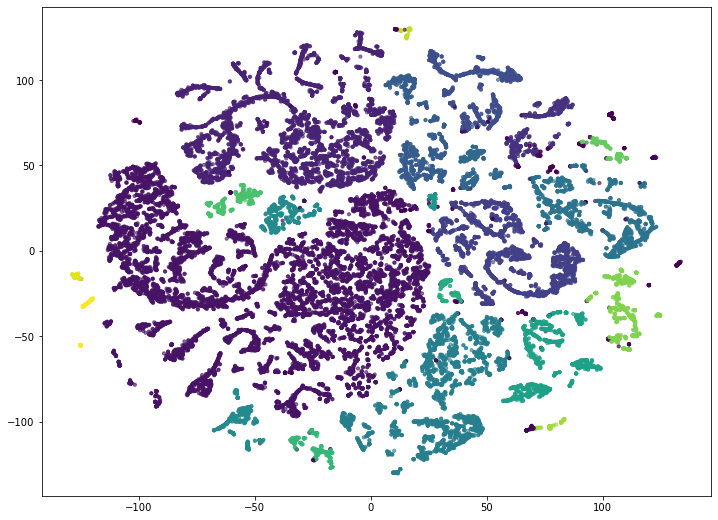

<Figure size 288x216 with 0 Axes>

In [64]:
#tamaño del punto, transparencia y resolución.

colors = labels.astype(np.float)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, cmap='viridis', s = 10, alpha = 0.6)
plt.rcParams["figure.figsize"] = (4, 3)
plt.figure(figsize=(4,3))
plt.show()

In [66]:
cols_to_keep = [col for col in dataframe2.columns if not col.startswith("anomalies")]

In [81]:
y = dataframe2['anomaliesAE'].values

In [84]:
np.count_nonzero(y == 1)

31179

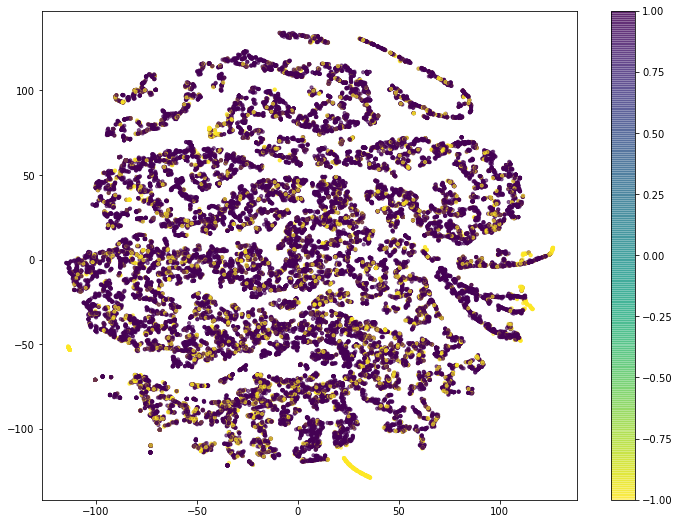

<Figure size 1728x1512 with 0 Axes>

In [71]:
#X = dataframe2[cols_to_keep].values
#y = dataframe2['anomaliesAE'].values

#tsne = TSNE(n_components=2, random_state=42)
#X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis_r', s = 10, alpha = 0.6)
plt.colorbar()
plt.rcParams["figure.figsize"] = (24, 21)
plt.figure(figsize=(24,21))
#plt.set_cmap('viridis_r')
plt.show()

In [74]:
np.count_nonzero(dataframe2['anomaliesIF'] == 1)

36563

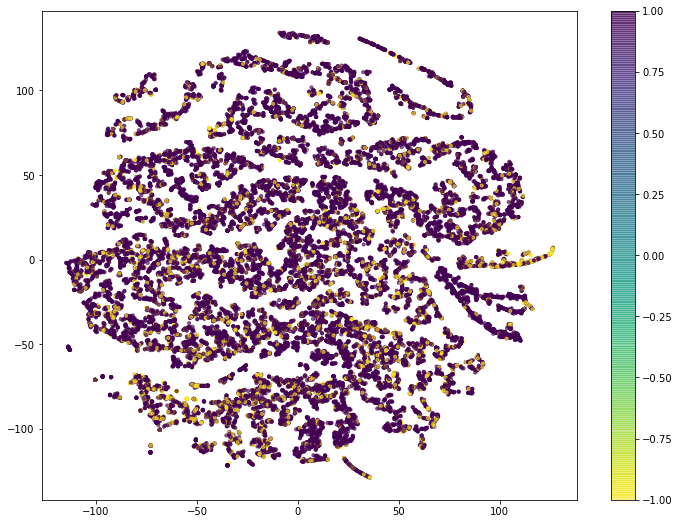

<Figure size 864x648 with 0 Axes>

In [90]:
#X = dataframe2[cols_to_keep].values
y = dataframe2['anomaliesIF'].values

#tsne = TSNE(n_components=2, random_state=42)
#X_tsne = tsne.fit_transform(X)

# Plot the t-SNE-transformed data
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis_r', s = 10, alpha = 0.6)
plt.colorbar()
plt.rcParams["figure.figsize"] = (12, 9)
plt.figure(figsize=(12,9))
#plt.set_cmap('viridis_r')
plt.show()

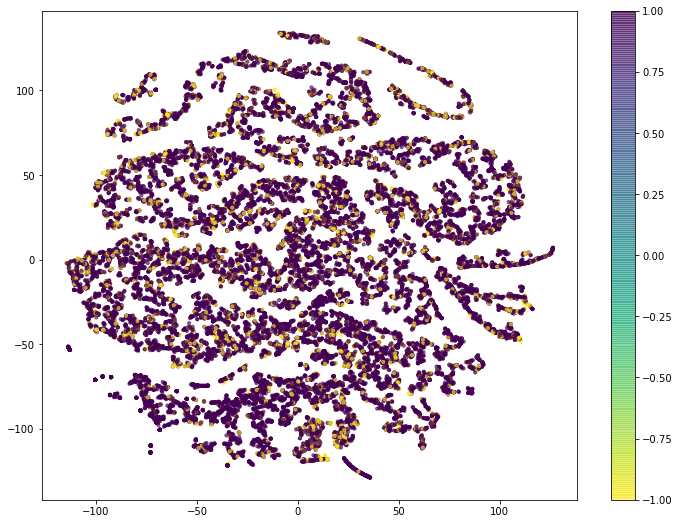

<Figure size 864x648 with 0 Axes>

In [91]:
#X = dataframe2[cols_to_keep].values
y = dataframe2['anomaliesLOF'].values

#tsne = TSNE(n_components=2, random_state=42)
#X_tsne = tsne.fit_transform(X)

# Plot the t-SNE-transformed data
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis_r', s = 10, alpha = 0.6)
plt.colorbar()
plt.rcParams["figure.figsize"] = (12, 9)
plt.figure(figsize=(12,9))
#plt.set_cmap('viridis_r')
plt.show()

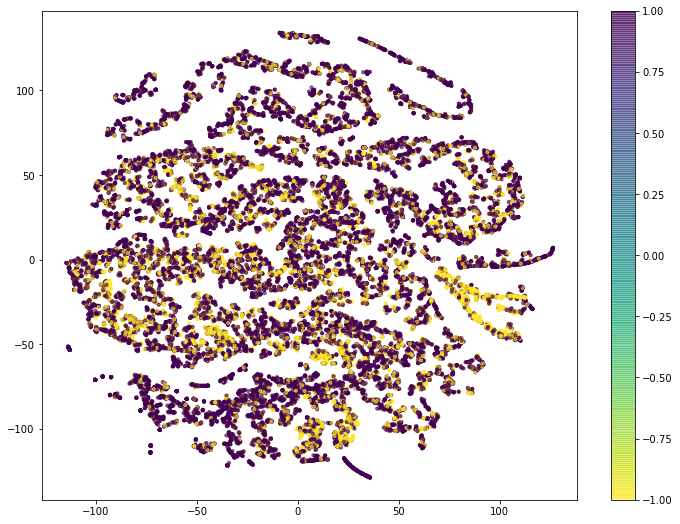

<Figure size 864x648 with 0 Axes>

In [97]:
#X = dataframe2[cols_to_keep].values
y = dataframe2['anomaliesSVM'].values

#tsne = TSNE(n_components=2, random_state=42)
#X_tsne = tsne.fit_transform(X)

# Plot the t-SNE-transformed data
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis_r', s = 10, alpha = 0.6)
plt.colorbar()
plt.rcParams["figure.figsize"] = (12, 9)
plt.figure(figsize=(12,9))
#plt.set_cmap('viridis_r')
plt.show()



### Asignamos las predicciones al dataframe

In [95]:
#Las anomalias se representan con -1 en todos los casos excepto en AE, donde se representan con un 1

dataframe2['anomaliesAE'] = predAE
dataframe2['anomaliesIF'] = predictions
dataframe2['anomaliesSVM'] = predSVM
dataframe2['anomaliesLOF'] = predLOF

In [28]:
dataframe2.head(5)

retweet_count  user.followers_count  user.friends_count  \
0            268                   288                  42   
1            945                  1386                5003   
2             65                   147                 107   
3              8                   664                1910   
6            405                  1828                 361   

   user.favourites_count  ratio_favs_followers  ratio_retweets_followers  \
0                  29833            103.586806                  0.930556   
1                  50479             36.420635                  0.681818   
2                    153              1.040816                  0.442177   
3                  59692             89.897590                  0.012048   
6                 642845            351.665755                  0.221554   

   number_emojis  created_after_war  num_tweets  ratio_tweets_dias  ...  \
0              0              False           2                2.0  ...   
1              1              False           1                1.0  ...   
2              0              False           1                1.0  ...   
3              0              False           7                7.0  ...   
6              0              False           1                1.0  ...   

   is_rt  are_mentions_in_tweet  num_mentions  num_mentions_user  cosine_avg  \
0   True                   True             1                  2    0.305142   
1   True                   True             1                  1    0.000000   
2   True                   True             1                  1    0.000000   
3   True                   True             1                  8    0.436056   
6   True                   True             1                  1    0.000000   

   num_rts  sentiment\r  anomaliesAE  anomaliesIF  anomaliesLOF  
0        2            0            0            1             1  
1        1            1            1            1             1  
2        1            1            0            1             1  
3        7            0            0            1             1  
6        1            0            0            1             1  

[5 rows x 23 columns]

In [29]:
dataframe2['anomaliesAE'] = list(map(lambda x: 1 if x == 0 else -1, dataframe2['anomaliesAE']))

### Visualizar el dataframe con las predicciones de los modelos

In [ ]:
dataframe2.head(10)

In [30]:
columnsOfInterest = ['retweet_count', 'user.followers_count', 'user.friends_count', 'ratio_favs_followers',
                    'ratio_retweets_followers', 'num_hashtags', 'num_tweets', 'ratio_tweets_dias',
                    'number_emojis', 'num_mentions', 'num_mentions_user', 'cosine_avg']

In [31]:
dataframeAE = dataframe2[dataframe2['anomaliesAE'] == -1]

In [43]:
df3 = pd.read_csv('Ukraine_tweets_World_50000_15_02_22_33.csv', lineterminator = '\n')
df3 = df3[df3['lang'].str.contains('en')]

In [44]:
df4 = df3.loc[dataframeAE.index]

In [45]:
def limpieza_texto_tweets(text):

    text = text.lower()
    text = re.sub(r',', ' ', text)
    text = re.sub(r'ç', 'c', text)
    text = re.sub(r'ñ', 'n', text)
    text = re.sub(r'\.', '', text)
    text = re.sub(r'á|é|í|ó|ú', lambda x: 'a' if x.group() == 'á' else 'e' if x.group() == 'é' else 'i' if x.group() == 'í' else 'o' if x.group() == 'ó' else 'u', text)
    text = re.sub(r'[^\x11-\x7F]+', ' ', text)
    text = re.sub(r'<.*>', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'RT', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'@', '', text)
    text = re.sub(r'\\x\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'_', '', text)
    text = re.sub(r'\t', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'rt', '', text)
    text = text.strip()
    
    return text

In [46]:
df4['text'].apply(limpieza_texto_tweets)

1                                                                                                noelrepos ukraine will win im sure of that
7                                                                                                          first us tank arrives in ukraine
12        nextatv the netherlands will transfer to ukraine 20 thousand ammunition for german leopard 2 tanks this was announced by the head
29                                                                                             ukrainiansquad ukraine proud of you soldiers
62                                                                                                                         wales is ukraine
                                                                        ...                                                                
49939                                                                              if theyre from nz and have the ukraine flag in their bio
49964               

In [47]:
dataframe2.loc[49853]

retweet_count                        0
user.followers_count               155
user.friends_count                 204
user.favourites_count            34911
ratio_favs_followers        225.232258
ratio_retweets_followers           0.0
number_emojis                        2
created_after_war                False
num_tweets                           1
ratio_tweets_dias                  1.0
lang_number                          1
num_hashtags                         0
is_image_default                 False
is_rt                            False
are_mentions_in_tweet             True
num_mentions                         1
num_mentions_user                    1
cosine_avg                         0.0
num_rts                              0
sentiment\r                          0
anomaliesAE                         -1
anomaliesIF                          1
anomaliesLOF                         1
Name: 49853, dtype: object

In [48]:
df4['text'].tail(30)

49763                   RT @DerrickEvans_WV: Democrats and RINOs claim we don’t have the money to upgrade basic infrastructure such as water/sewer plants in the US…
49768                                                                                      @Angel475B @Simca1942 @NDeitelhoff Fake News 🥱\r\nhttps://t.co/OUlKnJ6eys
49773                                                                                                      @ukraine_world Only 20% more to a perfect score troops 🇺🇦
49774                    RT @afneil: Reuters: Pakistan to quadruple domestic coal-fired capacity to reduce power generation costs; no new gas-fired plants planned.…
49801                                              RT @SlavaUk30722777: 🇺🇦The story of Polina from Volnovakha  #Ukraine who loves to paint❤️ https://t.co/xXXAPhS4Gd
49813                                                                                   World News: Russia and Ukraine Collides with Destiny https://t.co/e1woec5TAx
49827     

In [56]:
print(f"Average number of retweets: {round(dataframeAE['retweet_count'].mean(),4)} ------> Standard deviation: {round(dataframeAE['retweet_count'].std(),4)}")
print(f"Average number of languages: {round(dataframeAE['lang_number'].mean(),4)} ------> Standard deviation: {round(dataframeAE['lang_number'].std(),4)}")
print(f"User followers: {round(dataframeAE['user.followers_count'].mean(),4)} ------> Standard deviation: {round(dataframeAE['user.followers_count'].std(),4)}")
print(f"User followed: {round(dataframeAE['user.friends_count'].mean(),4)} ------> Standard deviation: {round(dataframeAE['user.friends_count'].std(),4)}")
print(f"Ratio favs_followers: {round(dataframeAE['ratio_favs_followers'].mean(),4)} ------> Standard deviation: {round(dataframeAE['ratio_favs_followers'].std(),4)}")
print(f"Ratio retweets_followers: {round(dataframeAE['ratio_retweets_followers'].mean(),4)} ------> Standard deviation: {round(dataframeAE['ratio_retweets_followers'].std(),4)}")
print(f"Average number of hashtags: {round(dataframeAE['num_hashtags'].mean(),4)} ------> Standard deviation: {round(dataframeAE['num_hashtags'].std(),4)}")
print(f"Average number of tweets: {round(dataframeAE['num_tweets'].mean(),4)} ------> Standard deviation: {round(dataframeAE['num_tweets'].std(),4)}")
print(f"Ratio tweets by day: {round(dataframeAE['ratio_tweets_dias'].mean(),4)} ------> Standard deviation: {round(dataframeAE['ratio_tweets_dias'].std(),4)}")
print(f"Average number of emojis: {round(dataframeAE['number_emojis'].mean(),4)} ------> Standard deviation: {round(dataframeAE['number_emojis'].std(),4)}")
print(f"Average number of mentions in each tweet: {round(dataframeAE['num_mentions'].mean(),4)} ------> Standard deviation: {round(dataframeAE['num_mentions'].std(),4)}")
print(f"Average number of mentions by user: {round(dataframeAE['num_mentions_user'].mean(),4)} ------> Standard deviation: {round(dataframeAE['num_mentions_user'].std(),4)}")
print(f"Average number of cosine similarity by user tweets: {round(dataframeAE['cosine_avg'].mean(),4)} ------> Standard deviation: {round(dataframeAE['cosine_avg'].std(),4)}")
print(f"Proportion of users created after the Ukraine war: {round(dataframeAE['created_after_war'].mean(),4)}")

Average number of retweets: 436.7385 ------> Standard deviation: 1858.5364
Average number of languages: 1.1307 ------> Standard deviation: 0.8083
User followers: 74495.0 ------> Standard deviation: 1201380.6388
User followed: 2719.342 ------> Standard deviation: 14063.7511
Ratio favs_followers: 262.5206 ------> Standard deviation: 2509.7836
Ratio retweets_followers: 44.4943 ------> Standard deviation: 412.7968
Average number of hashtags: 0.3524 ------> Standard deviation: 1.0538
Average number of tweets: 9.5341 ------> Standard deviation: 27.0061
Ratio tweets by day: 9.5341 ------> Standard deviation: 27.0061
Average number of emojis: 0.3147 ------> Standard deviation: 1.2765
Average number of mentions in each tweet: 0.9388 ------> Standard deviation: 0.9933
Average number of mentions by user: 10.5154 ------> Standard deviation: 33.0812
Average number of cosine similarity by user tweets: 0.1699 ------> Standard deviation: 0.2339
Proportion of users created after the Ukraine war: 0.2533

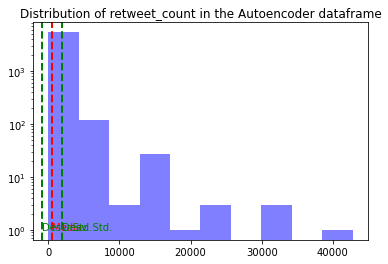

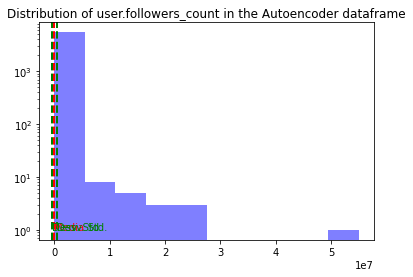

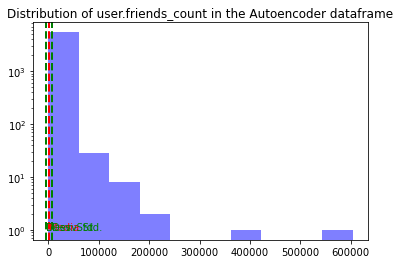

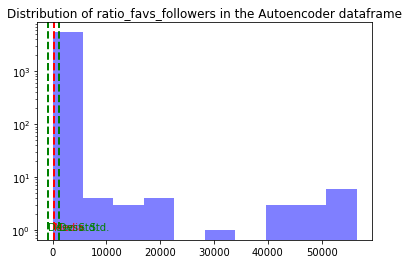

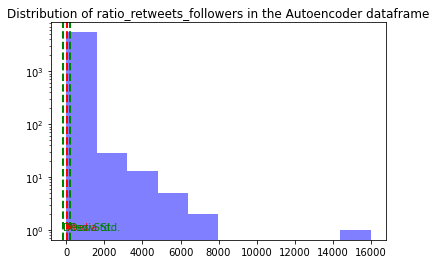

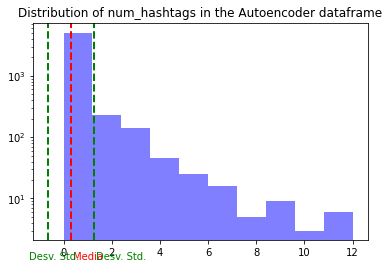

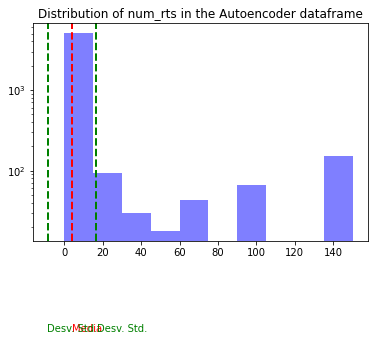

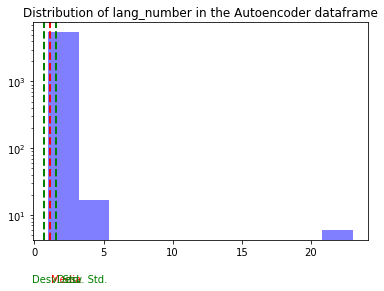

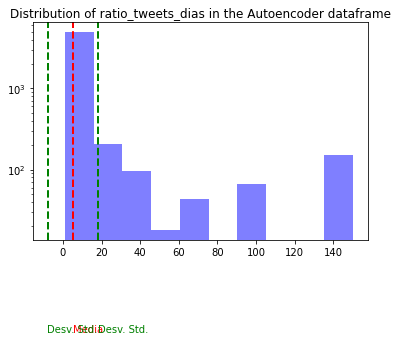

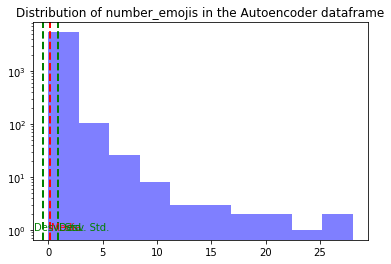

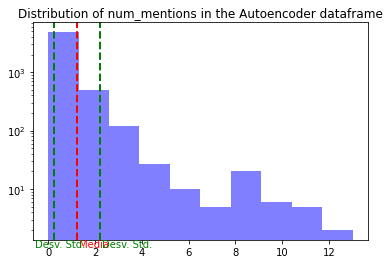

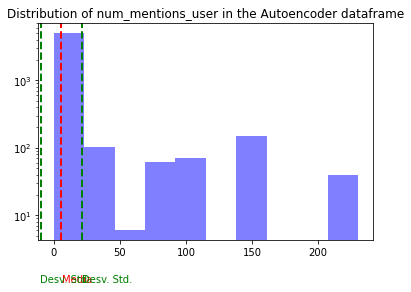

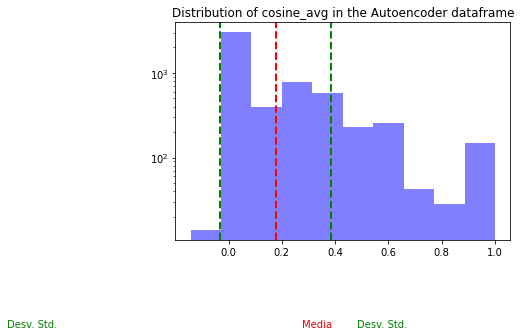

In [34]:
import matplotlib.pyplot as plt

lista_cols_interes = ['retweet_count', 'user.followers_count', 'user.friends_count', 'ratio_favs_followers',
                         'ratio_retweets_followers', 'num_hashtags', 'num_rts', 'lang_number', 'ratio_tweets_dias', 'number_emojis',
                         'num_mentions', 'num_mentions_user', 'cosine_avg']

for i in lista_cols_interes:
    datos = dataframeAE[i].tolist()
    media = round(dataframe2[i].mean(),4)
    desviacion_estandar = round(dataframe2[i].std(),4)

    plt.hist(datos, bins=10, alpha=0.5, color='blue')
    plt.title('Distribution of ' + i + ' in the Autoencoder dataframe')
    plt.axvline(x=media, color='red', linestyle='dashed', linewidth=2)
    plt.text(media+0.1, 1, 'Media', color='red')
    plt.axvline(x=media+desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
    plt.text(media+desviacion_estandar+0.1, 1, 'Desv. Std.', color='green')
    plt.axvline(x=media-desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
    plt.text(media-desviacion_estandar-0.8, 1, 'Desv. Std.', color='green')
    plt.yscale("log")
    plt.show()

In [109]:
dataframeIF = dataframe2[dataframe2['anomaliesIF'] == -1]

print(f"Average number of retweets: {round(dataframeIF['retweet_count'].mean(),4)} ------> Standard deviation: {round(dataframeIF['retweet_count'].std(),4)}")
print(f"Average number of languages: {round(dataframeIF['lang_number'].mean(),4)} ------> Standard deviation: {round(dataframeIF['lang_number'].std(),4)}")
print(f"User followers: {round(dataframeIF['user.followers_count'].mean(),4)} ------> Standard deviation: {round(dataframeIF['user.followers_count'].std(),4)}")
print(f"User followed: {round(dataframeIF['user.friends_count'].mean(),4)} ------> Standard deviation: {round(dataframeIF['user.friends_count'].std(),4)}")
print(f"Ratio favs_followers: {round(dataframeIF['ratio_favs_followers'].mean(),4)} ------> Standard deviation: {round(dataframeIF['ratio_favs_followers'].std(),4)}")
print(f"Ratio retweets_followers: {round(dataframeIF['ratio_retweets_followers'].mean(),4)} ------> Standard deviation: {round(dataframeIF['ratio_retweets_followers'].std(),4)}")
print(f"Average number of hashtags: {round(dataframeIF['num_hashtags'].mean(),4)} ------> Standard deviation: {round(dataframeIF['num_hashtags'].std(),4)}")
print(f"Average number of tweets: {round(dataframeIF['num_tweets'].mean(),4)} ------> Standard deviation: {round(dataframeIF['num_tweets'].std(),4)}")
print(f"Ratio tweets by day: {round(dataframeIF['ratio_tweets_dias'].mean(),4)} ------> Standard deviation: {round(dataframeIF['ratio_tweets_dias'].std(),4)}")
print(f"Average number of emojis: {round(dataframeIF['number_emojis'].mean(),4)} ------> Standard deviation: {round(dataframeIF['number_emojis'].std(),4)}")
print(f"Average number of mentions in each tweet: {round(dataframeIF['num_mentions'].mean(),4)} ------> Standard deviation: {round(dataframeIF['num_mentions'].std(),4)}")
print(f"Average number of mentions by user: {round(dataframeIF['num_mentions_user'].mean(),4)} ------> Standard deviation: {round(dataframeIF['num_mentions_user'].std(),4)}")
print(f"Average number of cosine similarity by user tweets: {round(dataframeIF['cosine_avg'].mean(),4)} ------> Standard deviation: {round(dataframeIF['cosine_avg'].std(),4)}")
print(f"Proportion of users created after the Ukraine war: {round(dataframeIF['created_after_war'].mean(),4)}")
    

Average number of retweets: 210.4021 ------> Standard deviation: 1069.857
Average number of languages: 1.115 ------> Standard deviation: 0.3722
User followers: 49706.3544 ------> Standard deviation: 734159.3686
User followed: 2429.7002 ------> Standard deviation: 12103.4668
Ratio favs_followers: 161.6375 ------> Standard deviation: 1027.5057
Ratio retweets_followers: 16.6008 ------> Standard deviation: 218.2659
Average number of hashtags: 0.3155 ------> Standard deviation: 0.9304
Average number of tweets: 6.1123 ------> Standard deviation: 16.1033
Ratio tweets by day: 6.1123 ------> Standard deviation: 16.1033
Average number of emojis: 0.2264 ------> Standard deviation: 0.9794
Average number of mentions in each tweet: 0.8906 ------> Standard deviation: 0.8015
Average number of mentions by user: 5.8795 ------> Standard deviation: 17.8813
Average number of cosine similarity by user tweets: 0.1664 ------> Standard deviation: 0.2195
Proportion of users created after the Ukraine war: 0.2553

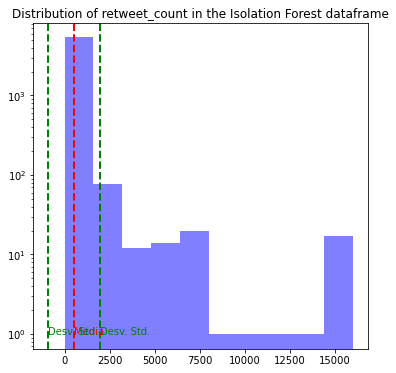

<Figure size 360x360 with 0 Axes>

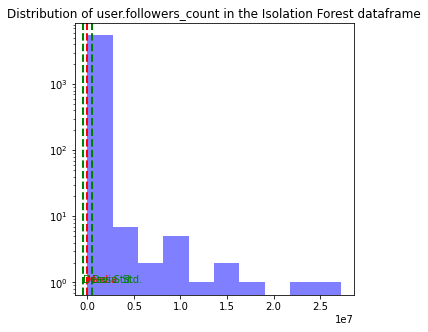

<Figure size 360x360 with 0 Axes>

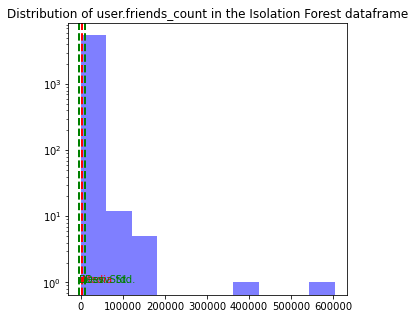

<Figure size 360x360 with 0 Axes>

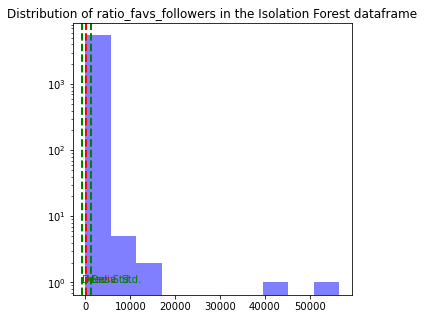

<Figure size 360x360 with 0 Axes>

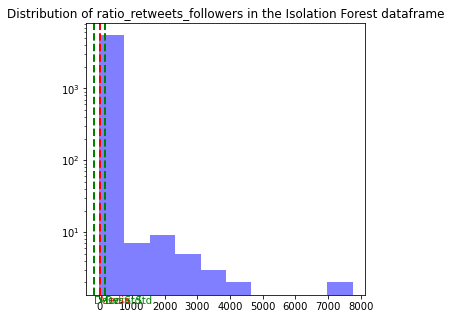

<Figure size 360x360 with 0 Axes>

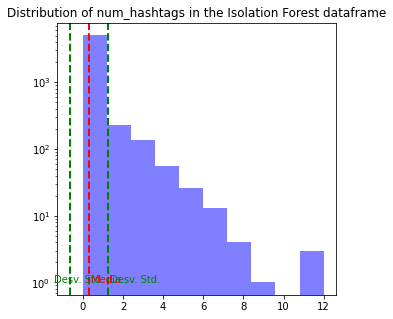

<Figure size 360x360 with 0 Axes>

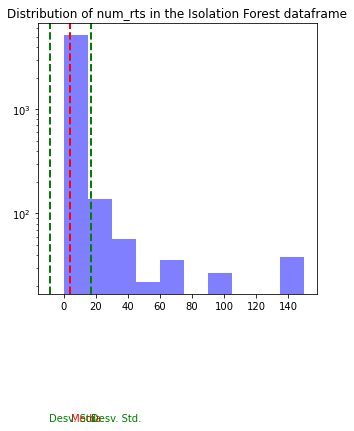

<Figure size 360x360 with 0 Axes>

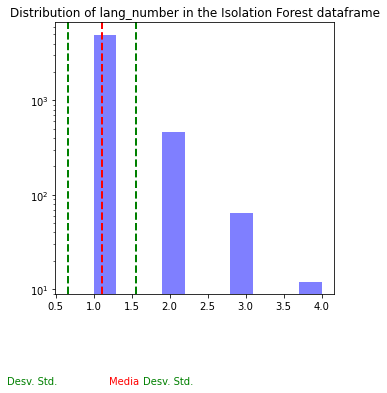

<Figure size 360x360 with 0 Axes>

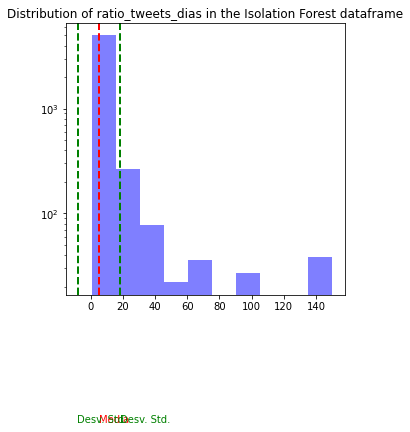

<Figure size 360x360 with 0 Axes>

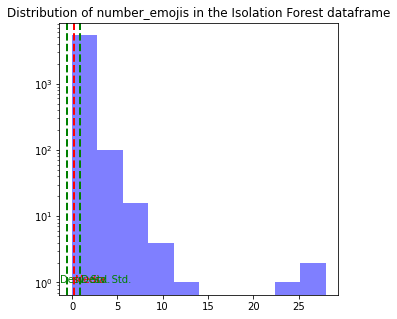

<Figure size 360x360 with 0 Axes>

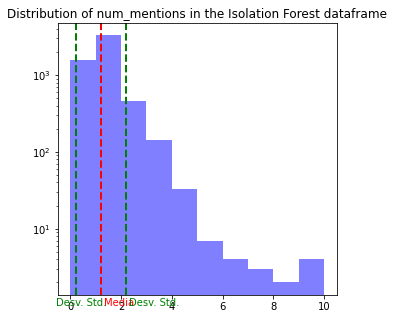

<Figure size 360x360 with 0 Axes>

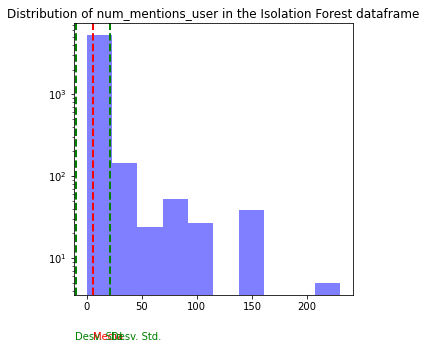

<Figure size 360x360 with 0 Axes>

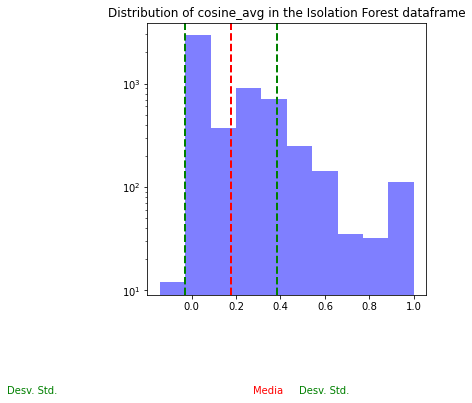

<Figure size 360x360 with 0 Axes>

In [116]:
for i in lista_cols_interes:
    datos = dataframeIF[i].tolist()
    media = round(dataframe2[i].mean(),4)
    desviacion_estandar = round(dataframe2[i].std(),4)

    plt.hist(datos, bins=10, alpha=0.5, color='blue')
    plt.title('Distribution of ' + i + ' in the Isolation Forest dataframe')
    plt.axvline(x=media, color='red', linestyle='dashed', linewidth=2)
    plt.text(media+0.1, 1, 'Media', color='red')
    plt.axvline(x=media+desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
    plt.text(media+desviacion_estandar+0.1, 1, 'Desv. Std.', color='green')
    plt.axvline(x=media-desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
    plt.text(media-desviacion_estandar-0.8, 1, 'Desv. Std.', color='green')
    plt.yscale("log")
    plt.show()

In [ ]:
df4 = df3.loc[dataframeIF.index]
df4['text'].apply(limpieza_texto_tweets)

In [59]:
df4.loc[49977]['text']

KeyError: 49977

In [58]:
dataframeLOF = dataframe2[dataframe2['anomaliesLOF'] == -1]

print(f"Average number of retweets: {round(dataframeLOF['retweet_count'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['retweet_count'].std(),4)}")
print(f"User followers: {round(dataframeLOF['user.followers_count'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['user.followers_count'].std(),4)}")
print(f"User followed: {round(dataframeLOF['user.friends_count'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['user.friends_count'].std(),4)}")
print(f"Ratio favs_followers: {round(dataframeLOF['ratio_favs_followers'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['ratio_favs_followers'].std(),4)}")
print(f"Ratio retweets_followers: {round(dataframeLOF['ratio_retweets_followers'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['ratio_retweets_followers'].std(),4)}")
print(f"Average number of hashtags: {round(dataframeLOF['num_hashtags'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['num_hashtags'].std(),4)}")
print(f"Average number of tweets: {round(dataframeLOF['num_tweets'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['num_tweets'].std(),4)}")
print(f"Ratio tweets by day: {round(dataframeLOF['ratio_tweets_dias'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['ratio_tweets_dias'].std(),4)}")
print(f"Average number of emojis: {round(dataframeLOF['number_emojis'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['number_emojis'].std(),4)}")
print(f"Average number of mentions in each tweet: {round(dataframeLOF['num_mentions'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['num_mentions'].std(),4)}")
print(f"Average number of mentions by user: {round(dataframeLOF['num_mentions_user'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['num_mentions_user'].std(),4)}")
print(f"Average number of cosine similarity by user tweets: {round(dataframeLOF['cosine_avg'].mean(),4)} ------> Standard deviation: {round(dataframeLOF['cosine_avg'].std(),4)}")
print(f"Proportion of users created after the Ukraine war: {round(dataframeLOF['created_after_war'].mean(),4)}")
    

Average number of retweets: 622.3649 ------> Standard deviation: 1556.9584
User followers: 9154.3794 ------> Standard deviation: 228196.8589
User followed: 2074.1325 ------> Standard deviation: 6422.7058
Ratio favs_followers: 323.5415 ------> Standard deviation: 1976.9648
Ratio retweets_followers: 46.2249 ------> Standard deviation: 323.8446
Average number of hashtags: 0.2868 ------> Standard deviation: 0.8191
Average number of tweets: 6.0336 ------> Standard deviation: 12.5679
Ratio tweets by day: 6.0336 ------> Standard deviation: 12.5679
Average number of emojis: 0.2153 ------> Standard deviation: 0.7511
Average number of mentions in each tweet: 1.1599 ------> Standard deviation: 0.5648
Average number of mentions by user: 6.7456 ------> Standard deviation: 13.7406
Average number of cosine similarity by user tweets: 0.1737 ------> Standard deviation: 0.182
Proportion of users created after the Ukraine war: 0.2958


In [ ]:
for i in columnsOfInterest:
    datos = dataframeLOF[i].tolist()
    media = round(dataframe2[i].mean(),4)
    desviacion_estandar = round(dataframe2[i].std(),4)

    plt.hist(datos, bins=10, alpha=0.5, color='blue')
    plt.title('Distribution of ' + i + ' in the Autoencoder dataframe')
    plt.axvline(x=media, color='red', linestyle='dashed', linewidth=2)
    plt.text(media+0.1, 1, 'Media', color='red')
    plt.axvline(x=media+desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
    plt.text(media+desviacion_estandar+0.1, 1, 'Desv. Std.', color='green')
    plt.axvline(x=media-desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
    plt.text(media-desviacion_estandar-0.8, 1, 'Desv. Std.', color='green')
    plt.show()

In [ ]:
df4 = df3.loc[dataframeLOF.index]
df4['text'].apply(limpieza_texto_tweets)

In [ ]:
df4.loc[49998]['text']

In [ ]:
dataframe2.to_csv("DataframeModels.csv")

In [51]:
dataframeFiltered = dataframe2[((dataframe2['anomaliesAE'] == -1) & (dataframe2['anomaliesIF'] == -1)) |
                              ((dataframe2['anomaliesAE'] == -1) & (dataframe2['anomaliesLOF'] == -1)) |
                              ((dataframe2['anomaliesIF'] == -1) & (dataframe2['anomaliesLOF'] == -1)) |
                              ((dataframe2['anomaliesAE'] == -1) & (dataframe2['anomaliesIF'] == -1) & (dataframe2['anomaliesLOF'] == -1))]

In [49]:
dataframeFiltered = dataframe2[((dataframe2['anomaliesAE'] == -1) & (dataframe2['anomaliesIF'] == -1) & (dataframe2['anomaliesLOF'] == -1))]

In [52]:
dataframeFiltered.shape

(4402, 23)

In [ ]:
dataframeFiltered2 = dataframe2[((dataframe2['anomaliesAE'] == -1) & (dataframe2['anomaliesIF'] == -1) & (dataframe2['anomaliesLOF'] == -1))]

In [ ]:
dataframeFiltered2.to_csv("dataframeFilteredAllSame.csv")

In [ ]:
dataframeFiltered.to_csv("dataframeFiltered.csv")

In [ ]:
df.iloc[790]['text']

### Mirar los dataframes generados

In [ ]:
dfFilter = pd.read_csv('dataframeFiltered.csv', lineterminator = '\n')

In [ ]:
df4 = df3.loc[dfFilter['Unnamed: 0'].tolist()]

In [ ]:
from matplotlib import pyplot as plt

for i in columnsOfInterest:
    datos = dfFilter[i].tolist()
    media = round(dataframe2[i].mean(),4)
    desviacion_estandar = round(dataframe2[i].std(),4)

    plt.hist(datos, bins=10, alpha=0.5, color='blue')
    plt.title('Distribution of ' + i + ' in the Autoencoder dataframe')
    plt.axvline(x=media, color='red', linestyle='dashed', linewidth=2)
    plt.text(media+0.1, 1, 'Media', color='red')
    plt.axvline(x=media+desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
    plt.text(media+desviacion_estandar+0.1, 1, 'Desv. Std.', color='green')
    plt.axvline(x=media-desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
    plt.text(media-desviacion_estandar-0.8, 1, 'Desv. Std.', color='green')
    plt.show()

In [ ]:
dfFilter2

In [ ]:
dfFilter2 = pd.read_csv('dataframeFilteredAllSame.csv', lineterminator = '\n')

In [ ]:
df4 = df3.loc[dfFilter2['Unnamed: 0'].tolist()]

In [ ]:
df4['text'] = df4['text'].apply(limpieza_texto_tweets)

In [ ]:
df4.loc[49109]['text']

In [ ]:
df4['text'].tail(40)

### Sacar un dataframe de solo los usuarios

In [ ]:
dataframe3 = df.drop_duplicates(subset = 'user.id')

In [ ]:
dataframe3 = dataframe3.filter(['user.followers_count', 'user.friends_count', 'user.favourites_count',
                             'ratio_favs_followers', 'ratio_retweets_followers', 'created_after_war', 'num_tweets', 'ratio_tweets_dias', 'langs','lang_number\r',
                             'num_hashtags', 'is_image_default','cosine_avg', 'num_rts\r'])

## Aplicar los modelos con el dataframe sin tweets

### Random Forest

In [ ]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(dataframe3)
model.decision_function(dataframe3)
predictions = model.predict(dataframe3)

anomalies = np.count_nonzero(predictions == -1)
notAnomalies = np.count_nonzero(predictions == 1)

print("Numero de anomalias segun Isolation Forest: " + str(anomalies))
print("Numero de no anomalias segun Isolation Forest: " + str(notAnomalies))

### Autoencoders

In [ ]:
atcdr = AutoEncoder(contamination=0.1, hidden_neurons =[2, 2])
history = atcdr.fit(dataframe3)
scores = atcdr.decision_function(dataframe3)
predAE = atcdr.predict(dataframe3)

anomaliesAE = np.count_nonzero(predAE == 1)
notAnomaliesAE = np.count_nonzero(predAE == 0)

print("Numero de anomalias con Autoencoders: " + str(anomaliesAE))
print("Numero de no anomalias con Autoencoders: " + str(notAnomaliesAE))

### Local Outlier Factor

In [ ]:
predLOF = lof.fit_predict(dataframe3)

print("Numero de anomalias con Local Outlier Factor: " + str(np.count_nonzero(predLOF == -1)))
print("Numero de no anomalias con Local Outlier Factor: " + str(np.count_nonzero(predLOF == 1)))

## Introducir los datos en el dataframe

In [ ]:
dataframe3['anomaliesIF'] = predictions
dataframe3['anomaliesLOF'] = predLOF
dataframe3['anomaliesAE'] = predAE

dataframe3['anomaliesAE'] = list(map(lambda x: 1 if x == 0 else -1, dataframe3['anomaliesAE']))

## Visualizar el nuevo dataframe de ususarios

In [ ]:
dataframe3.head(10)

In [ ]:
dataframe3[dataframe3['anomaliesAE'] == -1].head(15)

# Ignorar las lineas inferiores

In [ ]:
df.iloc[153]

In [ ]:
dataframe.head(20)

In [ ]:
dataframe

In [ ]:
print(df.iloc[3,17], df.iloc[3,1], df.iloc[3,2])

In [ ]:
dataframeAnomaliasIFAE = dataframe[(dataframe['anomaliesIF'] == -1) & (dataframe['anomaliesAE'] == 1)]

In [ ]:
dataframeAnomaliasIFAE.head(10)

In [ ]:
df.iloc[3067]['text']

In [ ]:
dataframeAnomaliasSVM = dataframe[(dataframe['anomaliesSVM'] == -1)]

In [ ]:
dataframeAnomaliasSVM.head(50)

In [ ]:
print(df.iloc[139,17], df.iloc[139,1], df.iloc[139,2])

In [ ]:
print(df.iloc[3570,17], df.iloc[3570,1], df.iloc[3570,2])

In [ ]:
print(df.iloc[3571,17], df.iloc[3571,1], df.iloc[3571,2])

In [ ]:
dataframeAnomaliasSVMLOF = dataframe[(dataframe['anomaliesSVM'] == -1) & (dataframe['anomaliesLOF'] == -1)]

In [ ]:
dataframeAnomaliasSVMLOF.head(20)

In [ ]:
print(df.iloc[620])

In [ ]:
print(df.iloc[16642,7], df.iloc[16642,6])

In [ ]:
print(df.iloc[16417,7], df.iloc[16417,6], df.iloc[16417,1])

In [ ]:
print(df.iloc[11098,7], df.iloc[11098,6], df.iloc[11098,1])

In [ ]:
print(df.iloc[9194,7], df.iloc[9194,6], df.iloc[9194,1])

In [ ]:
print(df.iloc[8363,7], df.iloc[8363,6], df.iloc[8363,1])

In [ ]:
print(dataframeAnomaliasSVMLOF.iloc[:30])

In [ ]:
print(df.iloc[3351,7], df.iloc[3351,6], df.iloc[3351,1])

In [ ]:
print(df.iloc[991,7], df.iloc[991,6], df.iloc[991,1])

In [ ]:
print(df.iloc[3194,7], df.iloc[3194,6], df.iloc[3194,1])

In [ ]:
print(df.iloc[2256,7], df.iloc[2256,6], df.iloc[2256,1])

In [ ]:
print(df.iloc[1867,7], df.iloc[1867,6], df.iloc[1867,1])

In [ ]:
print(df.iloc[253,7], df.iloc[253,6], df.iloc[253,1])

In [ ]:
print(df.iloc[1504,7], df.iloc[1504,6], df.iloc[1504,1])

In [ ]:
print(df.iloc[598,7], df.iloc[598,6], df.iloc[598,1])

Se pierden algunos trolls a la hora de añadir sentiment analysis
Se debe comprobar si con sentiment analysis detecta una mayor proporcion de trolls